# Simulated 4D-STEM Data: Large FOV Single Ripple Structure

In [1]:
# Import the python script containing the helper functions and classes
from fourdenoise import *
from ase.io import read
from abtem import *
from abTEM_helpers import * # module containing abTEM wrapper functions
import warnings
warnings.filterwarnings("ignore", message="Overspecified grid, the provided sampling is ignored")

# Using 'Arial' font for plots
plt.rcParams['font.family'] = 'Arial'

In [2]:
import os
import sys
os.chdir("C:/Users/haloe/Documents/CodeWriting/4Denoise/helpers")
sys.path.append("C:/Users/haloe/Documents/CodeWriting/4Denoise/")

os.getcwd()

### Load the atomic model and create a lattice

**Note:** We downloaded the `.cif` file of experimentally-verified $\text{MoSe}_2$ from [Materials Project](https://next-gen.materialsproject.org/materials/mp-1634?chemsys=Mo-Se). This model is for bilayer $\text{MoSe}_2$. To obtain the monolayer version, we used the software [VESTA](https://jp-minerals.org/vesta/en/download.html) to modify the cell. We provide the resulting model in `MoSe2_monolayer.cif`

In [10]:
atoms = read("./MoSe2_monolayer.cif")
atoms

Atoms(symbols='MoSe2', pbc=True, cell=[[3.32226, 0.0, 0.0], [-1.6611299999999993, 2.877161557976889, 0.0], [0.0, 0.0, 13.542956]], spacegroup_kinds=...)

We need to **orthogonalize** the cell for the multislice method to work. See section titled "*Orthogonal and periodic supercells*" under [Advanced Atomic Models](https://abtem.readthedocs.io/en/latest/user_guide/tutorials/advanced_atomic_models.html).

Additional transformations:
Euler angles (degrees): 	 x = 0.000, 	 y = -0.000, 	 z = -0.000
Normal strains (percent): 	 x = 0.000, 	 y = 0.000, 	 z = 0.000
Shear strains (percent): 	 xy = -0.000, 	 xz = 0.000, 	 xz = 0.000


(<Figure size 1200x400 with 2 Axes>,
 <Axes: title={'center': 'Side view of $MoSe_2$ Lattice'}, xlabel='x [Å]', ylabel='z [Å]'>)

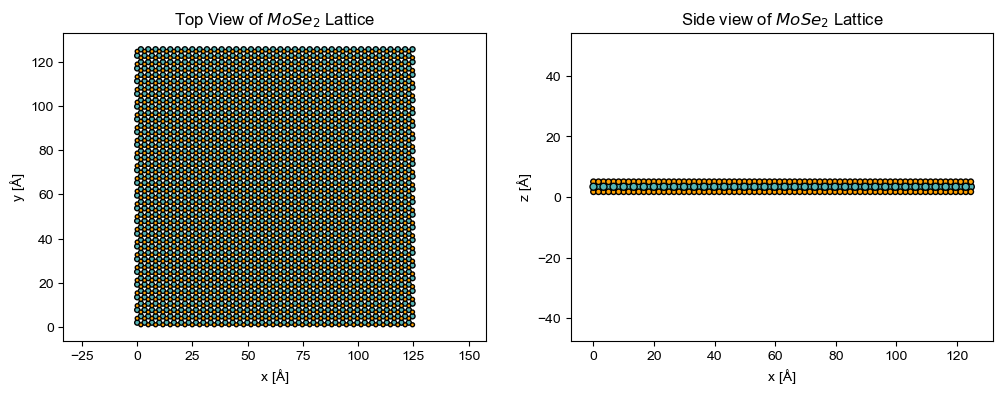

In [11]:
unit_cell_length = atoms.cell[0,0] # angstroms (alternatively, user can manually define the unit cell length)

# Define the approximate scale of the ripple model in angstroms per pixel
scale = 25 # Ang/px

# Repeat atom cell and orthogonalize it, as required by the multislice algorithm
atoms_orthogonalized, transform = orthogonalize_cell(atoms, return_transform=True)

from abtem.atoms import pretty_print_transform
print("Additional transformations:")
pretty_print_transform(transform)

n = 15
repetitions = (round(2.5*n), round(1.5*n), 1) # the (x, y, z) number of repetitions of the unit cell, we want it to be ~square-shaped
mose2_lattice = atoms_orthogonalized*repetitions

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
show_atoms(mose2_lattice, ax=ax1, title=r'Top View of $MoSe_2$ Lattice',show_cell=False, )
show_atoms(mose2_lattice, ax=ax2, plane='xz', title=r'Side view of $MoSe_2$ Lattice', show_cell=False )

In [12]:
# (Optional) Save the lattice to avoid rerunning the above
mose2_lattice.write('./mose2_lattice.cif', format='cif')

### Test *abTEM* electron diffraction simulations using lattice 

We define the variables $(\phi, \theta)$, where: 

* $\theta$ represents the **tilt** and 

* $\phi$ the **tilt axis** around which the tilt is measured from.

See figure below. These variables will be used to tilt the lattice and obtain the corresponding diffraction patterns.

We use the helper `rot_lattice` to apply three rotations in a fixed order. First, set the **tilt direction** with `phi_rot` (the in-plane azimuth that chooses the tilt axis). Next, apply the **tilt magnitude** with `theta_tilt` (the elevation angle—how far the lattice tips out of the xy-plane about that axis). Finally, `rotZ` makes any extra **spin about the z-axis** after the tilt.


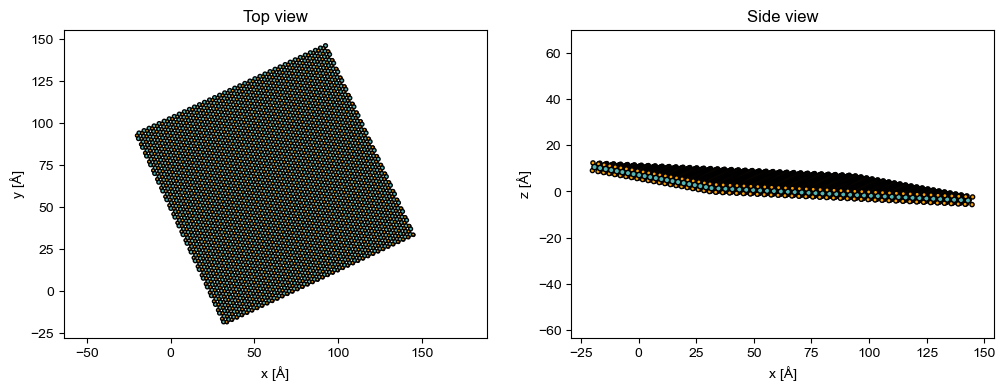

In [17]:
rot_lattice(mose2_lattice, theta_tilt=5, phi_rot=30, rotZ=25, cou=True, units='deg',)
plt.show()

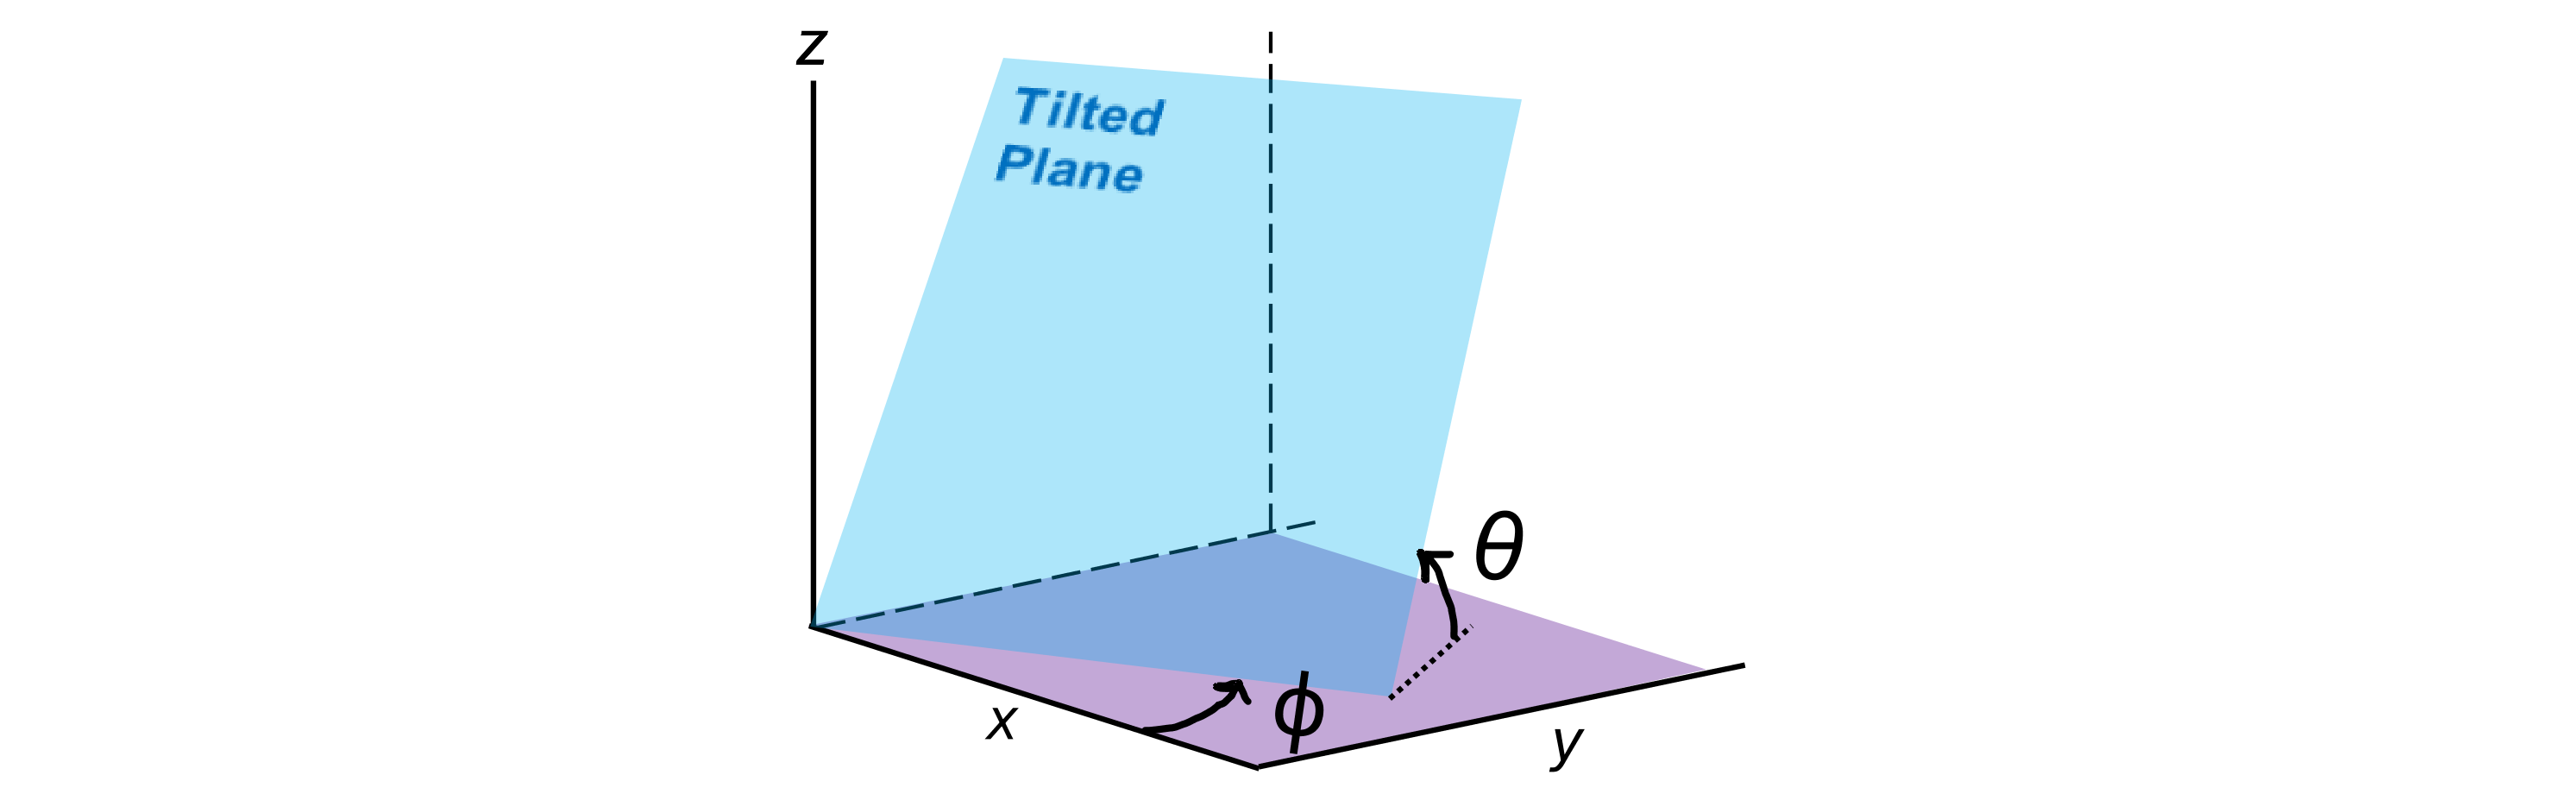

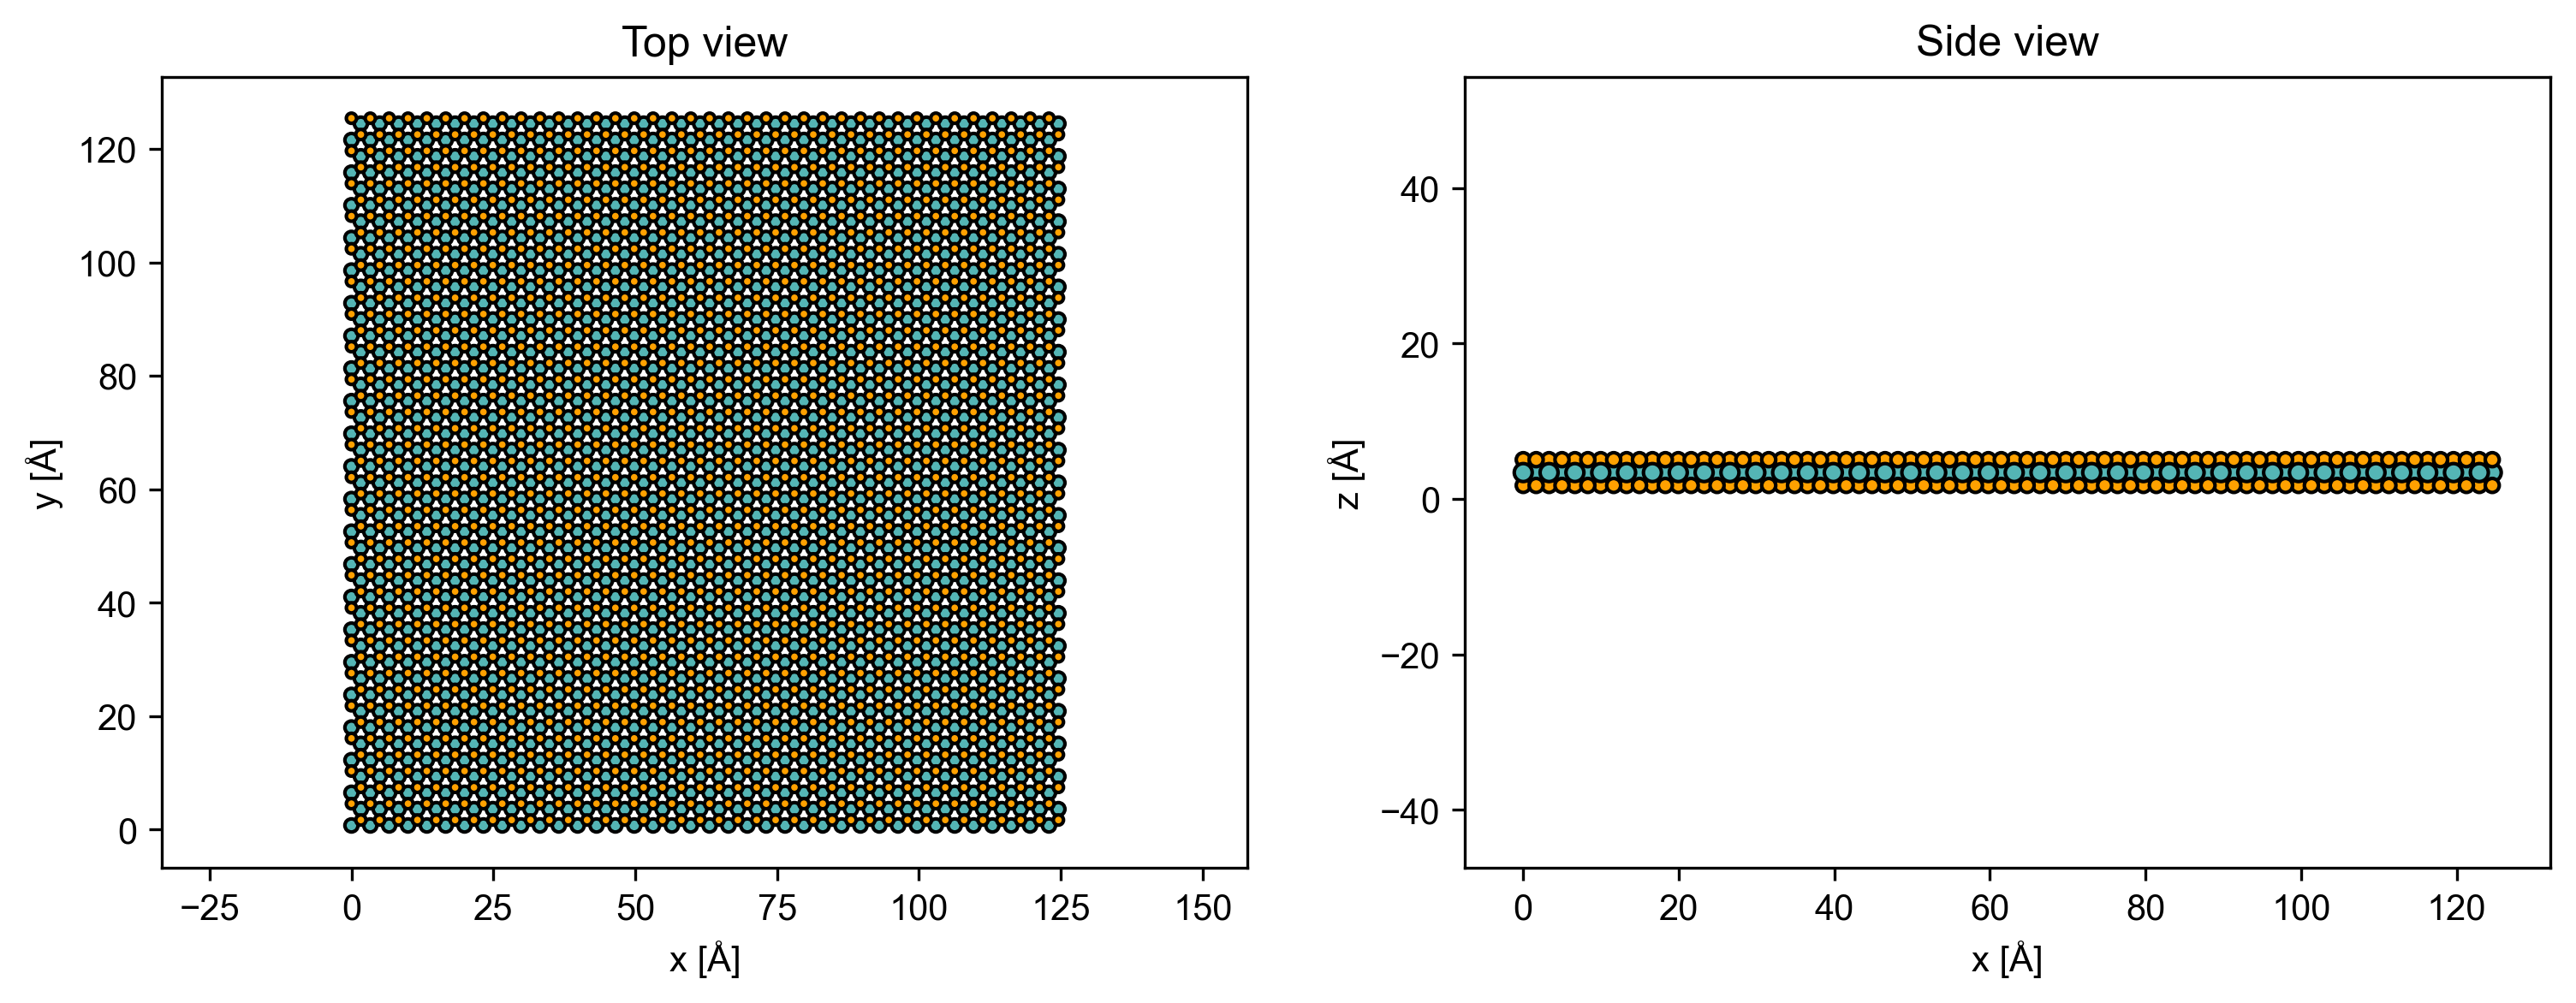

In [1953]:
# (Optional) If the lattice was previously saved, simply load the atoms object running this cell
wse2_lattice = read('wse2_lattice.cif')
# mose2_lattice = read('mose2_lattice_large.cif')
mose2_lattice = rot_lattice(mose2_lattice, theta_tilt=0, phi_rot=0, rotZ=90, cou=True)
plt.show()

We simulate diffraction patterns in a "flat" and "tilted" configuration for MoSe$_2$ and obtain the probe shape as well.

[########################################] | 100% Completed | 210.97 ms
Probe FWHM = 14.054717063903809 Å
[########################################] | 100% Completed | 2.38 sms
[########################################] | 100% Completed | 2.42 sms


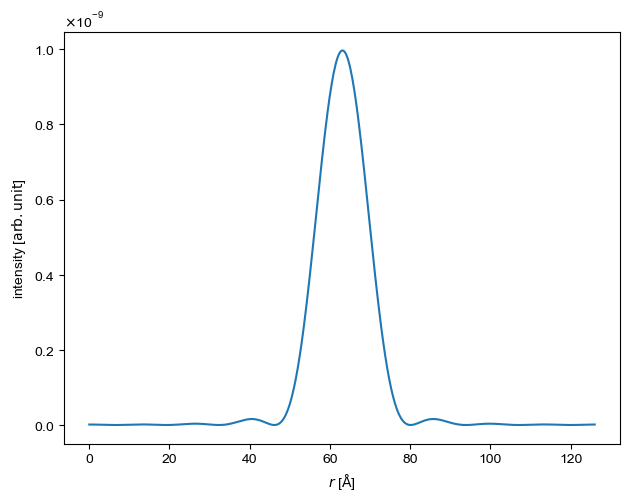

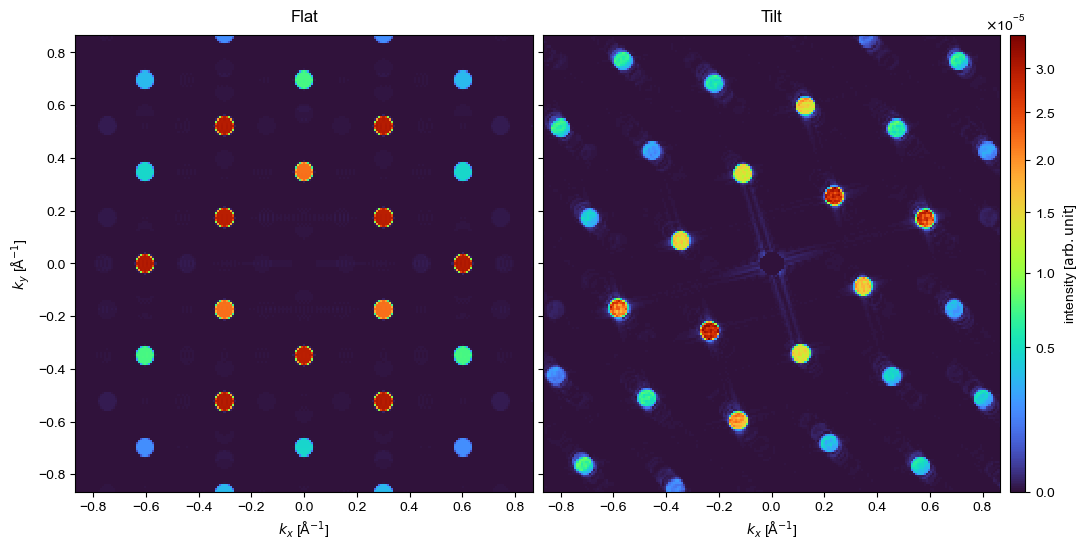

In [168]:
dp_flat = simulate_diff(mose2_lattice, 
                        theta_tilt=0, 
                        phi_rot=0, 
                        rotZ=0, 
                        energy=80e3, 
                        semiangle_cutoff=1.5, 
                        sampling_potential=0.2, 
                        slice_thickness=0.5,
                        sampling_probe=0.2, 
                        gpts=2**9, 
                        device='gpu', # alternatively, use 'cpu'
                        max_angle=42, 
                        units='deg',
                        get_probe_info=True,)

dp_tilt = simulate_diff(mose2_lattice, 
                        theta_tilt=15, # Arbitrary user choice just for visualization [0°, 25°]
                        phi_rot=25,    # Arbitrary user choice just for visualization [0°, 360°]
                        rotZ=17,       # Arbitrary user choice just for visualization [0°, 360°]
                        energy=80e3, 
                        semiangle_cutoff=1.5, 
                        sampling_potential=0.2, 
                        slice_thickness=0.5,
                        sampling_probe=0.2, 
                        gpts=2**9, 
                        device='gpu', # alternatively, use 'cpu'
                        max_angle=42, 
                        units='deg',
                        get_probe_info=False,)


diffraction_patterns = stack(
                                [
                                dp_flat.compute().block_direct(),
                                dp_tilt.compute().block_direct(),
                                ],
                                ("Flat", "Tilt"),
                            )

diffraction_patterns.show(
                             explode=True,
                             power=0.6,
                             figsize=(10*1.2, 6*1.2),
                             cbar=True,
                             common_color_scale=True,
                             cmap='turbo',
                         );



In [ ]:
# flat_centers = ReciprocalSpace(dp_flat.compute().array).get_centers(r=6, ref_coords=ref_coords)
# flat_intensities = ReciprocalSpace(dp_flat.compute().array).get_intensities(r=4.75, centers=flat_centers)

In [38]:
dp_flat.shape

(219, 219)

In [66]:
# Coordinates for n = 15
ref_coords = np.array([[42.8, 147],
                       [109.2, 184.9],
                       [175.2, 147],
                       [175.2, 70.8],
                       [109.2, 32.6],
                       [43.1, 70.8]])

### Generate a geometric ripple and obtain its corresponding tilt maps

In [30]:
# Load the ripple model and abTEM helper functions
from rippleModel import * # ripple, calculate_surface_tilt, phplot

We begin by modeling a **geometric ripple**, which is a common formation in lateral heterojunctions of materials with significant lattice mismatch.

In [31]:
# Run this to see the docstring describing the influence of each of the model's parameters.
ripple?

Signature:
ripple(
    t=3.5,
    n=25.0,
    k=4.6,
    m=3,
    p=4.2,
    res=1,
    show_ripple_data=True,
    crop_size=None,
    return_full_ripple=True,
)
Docstring:
Generates a symmetrical ripple pattern based on mathematical transformations.

This function creates a ripple effect using trigonometric manipulations,
where parameters control various aspects of the ripple's appearance such as
width, sharpness, and edge characteristics. The ripple is symmetrically
reflected to form a full pattern.

Parameters
----------
t : float
    Influences the width of each ripple along the x-axis. Higher 't' values
    result in wider ripples. Default is 3.5.
n : float
    Controls the sharpness of the amplitude decrease in a direction parallel
    to the ripple. Higher 'n' results in a more rectangular ripple (as 
    viewed from the side). Default is 25.
k : float
    Affects the widening of the ripple ends. Higher 'k' values result in wider
    ripple ends, while lower values result in no 

In [41]:
# Run the ripple model to visualize it

ripple_map = ripple(t=3, n=25, k=4.6, m=3, p=4.2, res=1, show_ripple_data=False, crop_size=3)*1.31

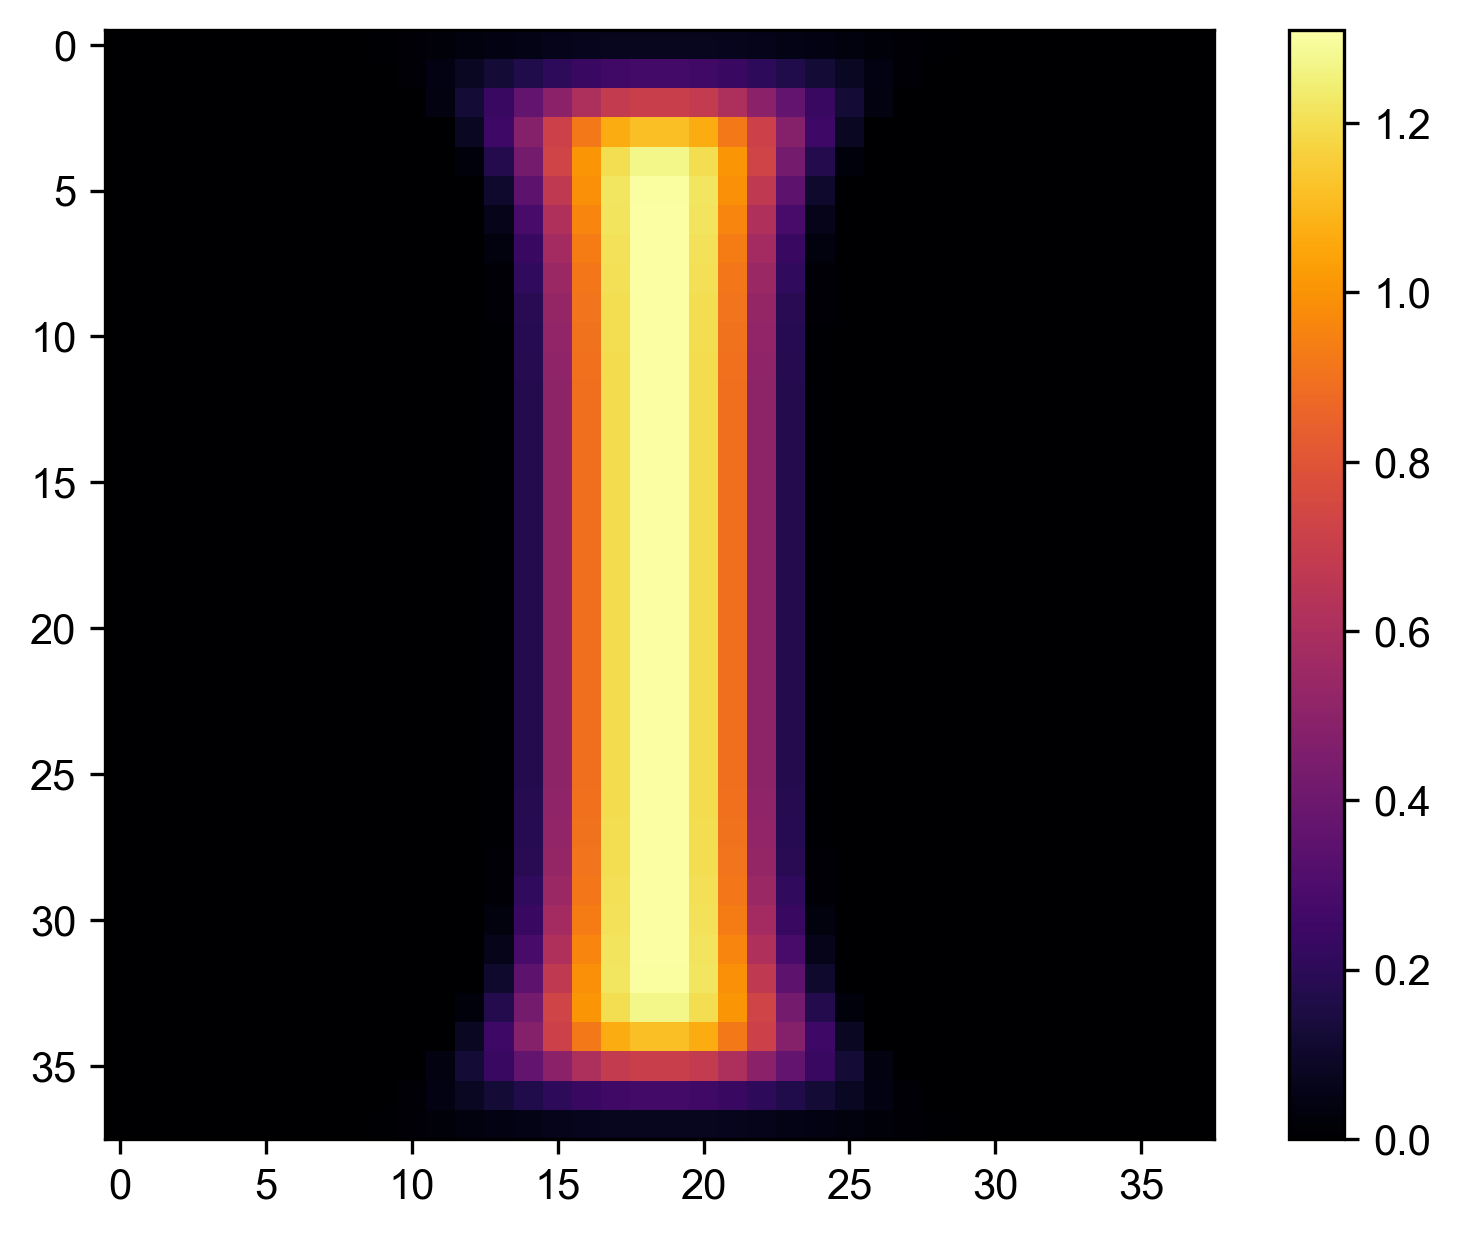

In [129]:
plt.figure(dpi=300)
plt.imshow(rotate(ripple_map,0), cmap='inferno')
plt.colorbar()
plt.show()

In [142]:
# Save the generated ripple 
np.save('geometric_ripple.npy', ripple_map)
# ripple_map = np.load('geometric_ripple.npy')

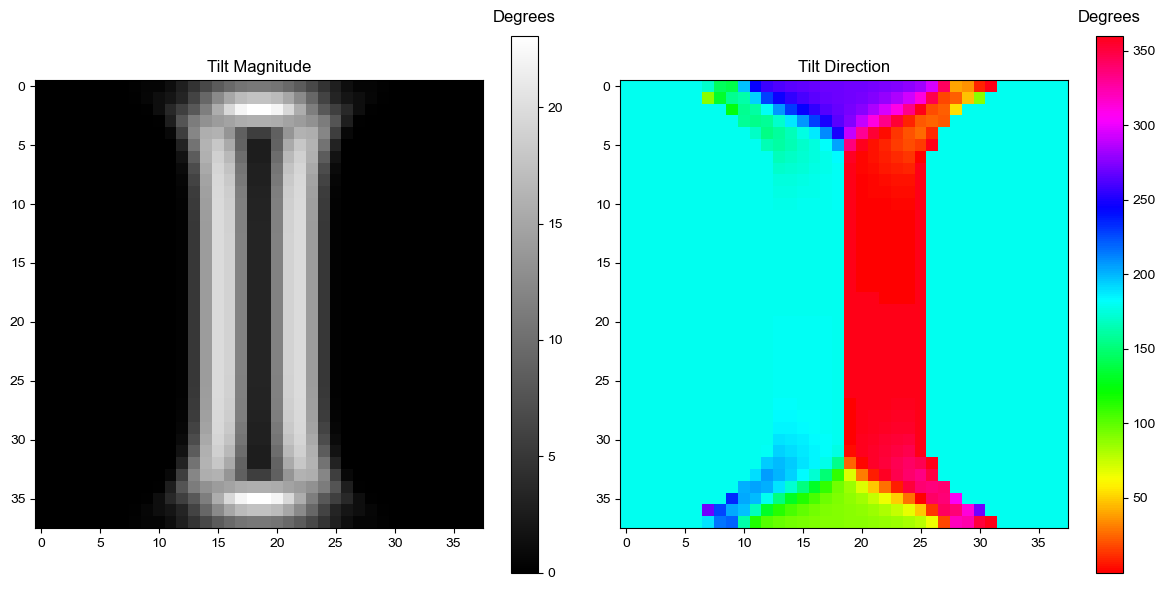

In [43]:
# We now collect the tilt and tilt-axis arrays from the simulated ripple array. This will serve to specify specific orientations
# for simulating diffraction patterns and obtaining a 4D dataset.

ripple_tilt, ripple_tilt_axis = calculate_surface_tilt(ripple_map, units='deg', show_results=True, )

# optionally, save the data
np.save('phi_geometric_ripple.npy', ripple_tilt_axis)
np.save('theta_geometric_ripple.npy', ripple_tilt)

In [44]:
np.max(ripple_tilt)

23.07396

In [144]:
ripple_tilt_axis -= 360

In [69]:
phplot?

Signature: phplot(field1, Amp='raw', scale=True, subplot=True)
Docstring:
Visualize the phase and amplitude of a field as an RGB image and optionally display a color wheel.

Parameters
----------
field1 : complex ndarray or tuple
    The input field. Can be a complex array or a tuple of (phase, magnitude).
Amp : str, optional
    Control for amplitude visualization:
    'uniform' - use a uniform amplitude across the image,
    'log' - use logarithmic scaling of the amplitude,
    'raw' - use the raw amplitude values.
scale : bool, optional
    If True, plots a color wheel with corresponding phase hues. Default is False.
subplot : bool, optional
    If True, uses subplots to show the image and color wheel; otherwise, separate figures.

Returns
-------
rgb_image : ndarray
    An array representing the RGB visualization of the input field.

Notes
-----
This code is based on the MATLAB code written by [author] in [date].
File:      c:\users\haloe\documents\codewriting\4denoise\helpers\ripp

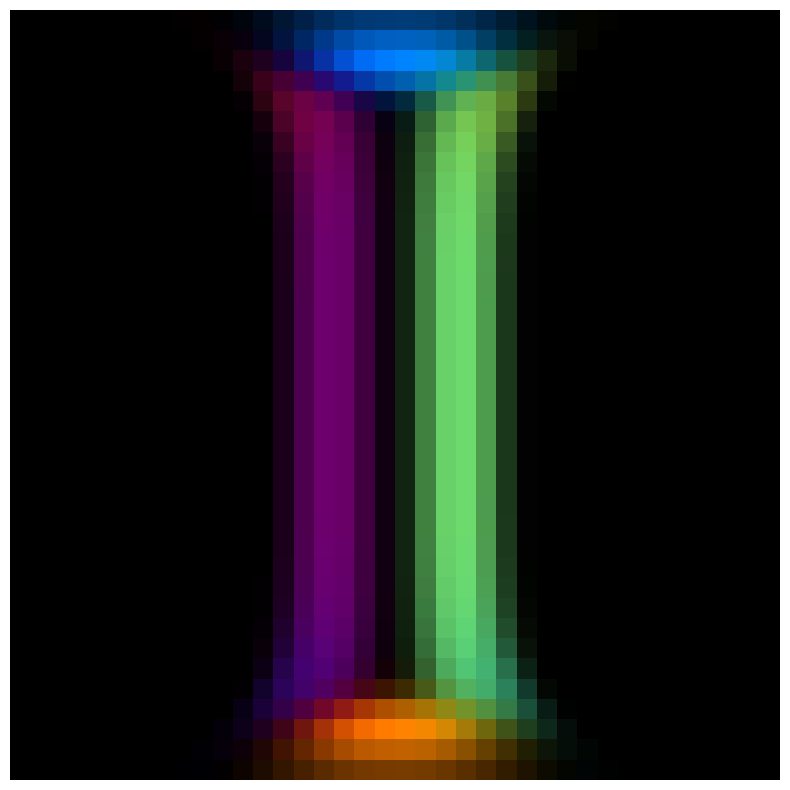

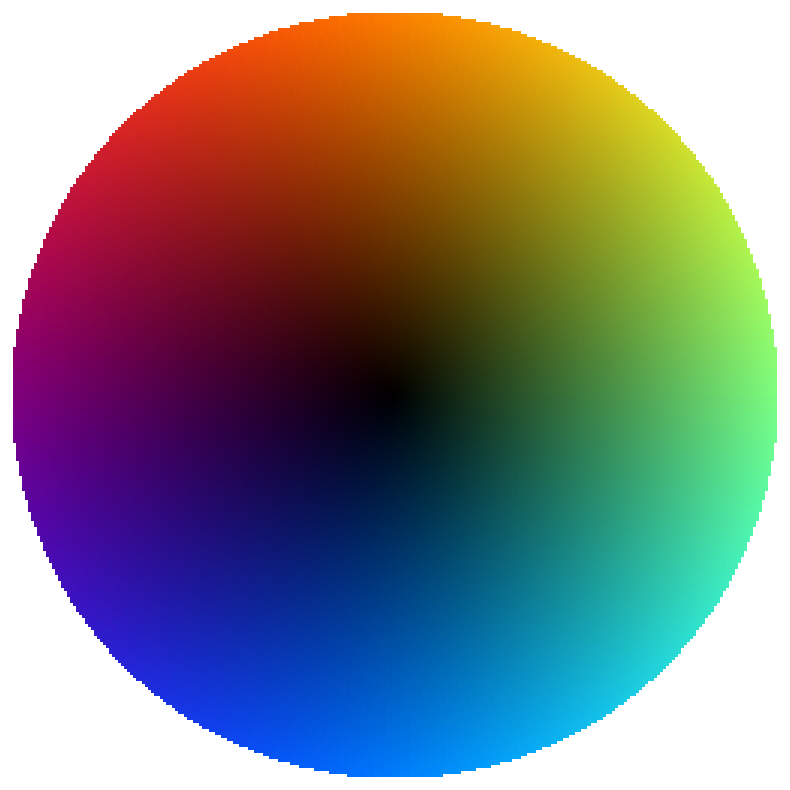

In [57]:
# Visualize a plot of combined amplitude and phase. 
phplot((np.radians(ripple_tilt_axis), ripple_tilt), Amp='raw', scale=True, subplot=False);

### Generate a 4D dataset using the ripple's tilt data

**Note:** We must initialize a 4D array that matches the real-space shape of the ripple and the reciprocal-space of the diffraction patterns. For the reciprocal-space, we use the dimensions of the diffraction patterns we simulated above (`dp_flat` and `dp_tilt`).

In [1695]:
ky, kx = dp_flat.array.shape
ny, nx = ripple_map.shape

# Initialize simulated 4D dataset
ripple_dataset = np.zeros((ny, nx, ky, kx), dtype=np.float32)

for y in tqdm(range(ny)):
    for x in range(nx):
        
        theta, phi = (ripple_tilt[y, x], ripple_tilt_axis[y, x])
                
        tilted_diffraction = simulate_diff(mose2_lattice, theta_tilt=theta, phi_rot=phi, rotZ=0, energy=80e3, 
                              semiangle_cutoff=1.5, sampling_potential=0.2, slice_thickness=0.5,
                              sampling_probe=0.2, gpts=2**9, device='gpu', max_angle=42, units='deg')    
        
        # Resize to square matrix and add to 4D dataset
        ripple_dataset[y, x] = tilted_diffraction.compute().array

# Optionally, save the 4D dataset
np.save('simulated_4d_dataset_highRes.npy', ripple_dataset)

  0%|                                                                                           | 0/38 [00:00<?, ?it/s]

[########################################] | 100% Completed |  1.6s
[########################################] | 100% Completed |  1.5s
[########################################] | 100% Completed |  1.9s
[########################################] | 100% Completed |  2.4s
[########################################] | 100% Completed |  2.4s
[########################################] | 100% Completed |  2.3s
[########################################] | 100% Completed |  4.3s
[########################################] | 100% Completed |  1.5s
[########################################] | 100% Completed |  2.9s
[########################################] | 100% Completed |  2.6s
[########################################] | 100% Completed |  3.0s
[########################################] | 100% Completed |  2.5s
[########################################] | 100% Completed |  3.2s
[########################################] | 100% Completed |  3.4s
[########################################] | 100

  3%|██                                                                              | 1/38 [01:44<1:04:13, 104.15s/it]

[########################################] | 100% Completed |  2.8s
[########################################] | 100% Completed |  2.2s
[########################################] | 100% Completed |  2.1s
[########################################] | 100% Completed |  1.5s
[########################################] | 100% Completed |  1.6s
[########################################] | 100% Completed |  2.5s
[########################################] | 100% Completed |  2.6s
[########################################] | 100% Completed |  2.6s
[########################################] | 100% Completed |  2.5s
[########################################] | 100% Completed |  2.6s
[########################################] | 100% Completed |  2.9s
[########################################] | 100% Completed |  3.2s
[########################################] | 100% Completed |  3.4s
[########################################] | 100% Completed |  3.9s
[########################################] | 100

  5%|████▏                                                                           | 2/38 [03:30<1:03:14, 105.40s/it]

[########################################] | 100% Completed |  2.0s
[########################################] | 100% Completed |  3.3s
[########################################] | 100% Completed |  2.8s
[########################################] | 100% Completed |  2.6s
[########################################] | 100% Completed |  1.7s
[########################################] | 100% Completed |  2.8s
[########################################] | 100% Completed |  2.6s
[########################################] | 100% Completed |  2.6s
[########################################] | 100% Completed |  2.9s
[########################################] | 100% Completed |  2.6s
[########################################] | 100% Completed |  2.8s
[########################################] | 100% Completed |  4.0s
[########################################] | 100% Completed |  3.6s
[########################################] | 100% Completed |  2.8s
[########################################] | 100

  8%|██████▎                                                                         | 3/38 [05:24<1:03:41, 109.18s/it]

[########################################] | 100% Completed |  2.2s
[########################################] | 100% Completed |  2.6s
[########################################] | 100% Completed |  2.7s
[########################################] | 100% Completed |  2.9s
[########################################] | 100% Completed |  2.9s
[########################################] | 100% Completed |  2.4s
[########################################] | 100% Completed |  2.5s
[########################################] | 100% Completed |  2.1s
[########################################] | 100% Completed |  1.2s
[########################################] | 100% Completed |  2.3s
[########################################] | 100% Completed |  3.2s
[########################################] | 100% Completed |  2.1s
[########################################] | 100% Completed |  2.9s
[########################################] | 100% Completed |  2.4s
[########################################] | 100

 11%|████████▋                                                                         | 4/38 [06:57<58:25, 103.11s/it]

[########################################] | 100% Completed |  3.0s
[########################################] | 100% Completed |  2.3s
[########################################] | 100% Completed |  1.2s
[########################################] | 100% Completed |  1.6s
[########################################] | 100% Completed |  3.0s
[########################################] | 100% Completed |  2.6s
[########################################] | 100% Completed |  2.7s
[########################################] | 100% Completed |  2.8s
[########################################] | 100% Completed |  3.4s
[########################################] | 100% Completed |  2.4s
[########################################] | 100% Completed |  2.6s
[########################################] | 100% Completed |  2.8s
[########################################] | 100% Completed |  2.6s
[########################################] | 100% Completed |  2.9s
[########################################] | 100

 13%|██████████▊                                                                       | 5/38 [08:42<56:56, 103.54s/it]

[########################################] | 100% Completed |  2.5s
[########################################] | 100% Completed |  2.6s
[########################################] | 100% Completed |  2.4s
[########################################] | 100% Completed |  3.0s
[########################################] | 100% Completed |  1.5s
[########################################] | 100% Completed |  2.4s
[########################################] | 100% Completed |  2.6s
[########################################] | 100% Completed |  2.8s
[########################################] | 100% Completed |  2.8s
[########################################] | 100% Completed |  1.4s
[########################################] | 100% Completed |  2.2s
[########################################] | 100% Completed |  2.3s
[########################################] | 100% Completed |  4.0s
[########################################] | 100% Completed |  3.3s
[########################################] | 100

 16%|████████████▉                                                                     | 6/38 [10:28<55:47, 104.62s/it]

[########################################] | 100% Completed |  3.1s
[########################################] | 100% Completed |  2.8s
[########################################] | 100% Completed |  2.9s
[########################################] | 100% Completed |  2.0s
[########################################] | 100% Completed |  1.7s
[########################################] | 100% Completed |  2.8s
[########################################] | 100% Completed |  2.7s
[########################################] | 100% Completed |  1.7s
[########################################] | 100% Completed |  2.7s
[########################################] | 100% Completed |  2.9s
[########################################] | 100% Completed |  2.7s
[########################################] | 100% Completed |  2.6s
[########################################] | 100% Completed |  2.7s
[########################################] | 100% Completed |  3.7s
[########################################] | 100

 18%|███████████████                                                                   | 7/38 [12:12<53:53, 104.30s/it]

[########################################] | 100% Completed |  2.9s
[########################################] | 100% Completed |  2.7s
[########################################] | 100% Completed |  2.6s
[########################################] | 100% Completed |  3.2s
[########################################] | 100% Completed |  2.1s
[########################################] | 100% Completed |  2.6s
[########################################] | 100% Completed |  2.2s
[########################################] | 100% Completed |  2.7s
[########################################] | 100% Completed |  2.6s
[########################################] | 100% Completed |  2.8s
[########################################] | 100% Completed |  2.7s
[########################################] | 100% Completed |  3.2s
[########################################] | 100% Completed |  2.8s
[########################################] | 100% Completed |  3.3s
[########################################] | 100

 21%|█████████████████▎                                                                | 8/38 [14:02<53:04, 106.14s/it]

[########################################] | 100% Completed |  2.6s
[########################################] | 100% Completed |  2.8s
[########################################] | 100% Completed |  2.2s
[########################################] | 100% Completed |  2.6s
[########################################] | 100% Completed |  3.1s
[########################################] | 100% Completed |  2.9s
[########################################] | 100% Completed |  2.8s
[########################################] | 100% Completed |  2.2s
[########################################] | 100% Completed |  1.5s
[########################################] | 100% Completed |  2.3s
[########################################] | 100% Completed |  2.2s
[########################################] | 100% Completed |  2.6s
[########################################] | 100% Completed |  3.1s
[########################################] | 100% Completed |  2.6s
[########################################] | 100

 24%|███████████████████▍                                                              | 9/38 [15:45<50:50, 105.20s/it]

[########################################] | 100% Completed |  2.1s
[########################################] | 100% Completed |  2.2s
[########################################] | 100% Completed |  2.7s
[########################################] | 100% Completed |  2.7s
[########################################] | 100% Completed |  2.7s
[########################################] | 100% Completed |  3.3s
[########################################] | 100% Completed |  2.3s
[########################################] | 100% Completed |  2.0s
[########################################] | 100% Completed |  2.9s
[########################################] | 100% Completed |  3.0s
[########################################] | 100% Completed |  1.7s
[########################################] | 100% Completed |  2.8s
[########################################] | 100% Completed |  1.9s
[########################################] | 100% Completed |  2.6s
[########################################] | 100

 26%|█████████████████████▎                                                           | 10/38 [17:28<48:40, 104.30s/it]

[########################################] | 100% Completed |  2.9s
[########################################] | 100% Completed |  2.6s
[########################################] | 100% Completed |  2.6s
[########################################] | 100% Completed |  2.7s
[########################################] | 100% Completed |  1.8s
[########################################] | 100% Completed |  2.3s
[########################################] | 100% Completed |  1.8s
[########################################] | 100% Completed |  2.1s
[########################################] | 100% Completed |  3.0s
[########################################] | 100% Completed |  3.6s
[########################################] | 100% Completed |  2.2s
[########################################] | 100% Completed |  2.4s
[########################################] | 100% Completed |  2.2s
[########################################] | 100% Completed |  3.7s
[########################################] | 100

 29%|███████████████████████▍                                                         | 11/38 [19:10<46:38, 103.64s/it]

[########################################] | 100% Completed |  1.8s
[########################################] | 100% Completed |  2.4s
[########################################] | 100% Completed |  2.1s
[########################################] | 100% Completed |  1.8s
[########################################] | 100% Completed |  1.6s
[########################################] | 100% Completed |  2.3s
[########################################] | 100% Completed |  2.7s
[########################################] | 100% Completed |  1.5s
[########################################] | 100% Completed |  1.7s
[########################################] | 100% Completed |  1.9s
[########################################] | 100% Completed |  2.4s
[########################################] | 100% Completed |  2.5s
[########################################] | 100% Completed |  2.2s
[########################################] | 100% Completed |  3.8s
[########################################] | 100

 32%|█████████████████████████▉                                                        | 12/38 [20:41<43:17, 99.90s/it]

[########################################] | 100% Completed |  1.8s
[########################################] | 100% Completed |  1.7s
[########################################] | 100% Completed |  2.2s
[########################################] | 100% Completed |  1.8s
[########################################] | 100% Completed |  1.9s
[########################################] | 100% Completed |  2.3s
[########################################] | 100% Completed |  2.6s
[########################################] | 100% Completed |  2.7s
[########################################] | 100% Completed |  2.0s
[########################################] | 100% Completed |  2.7s
[########################################] | 100% Completed |  2.7s
[########################################] | 100% Completed |  2.9s
[########################################] | 100% Completed |  2.0s
[########################################] | 100% Completed |  3.6s
[########################################] | 100

 34%|████████████████████████████                                                      | 13/38 [22:16<41:00, 98.42s/it]

[########################################] | 100% Completed |  3.0s
[########################################] | 100% Completed |  3.0s
[########################################] | 100% Completed |  2.3s
[########################################] | 100% Completed |  2.8s
[########################################] | 100% Completed |  2.1s
[########################################] | 100% Completed |  1.2s
[########################################] | 100% Completed |  1.7s
[########################################] | 100% Completed |  2.0s
[########################################] | 100% Completed |  2.0s
[########################################] | 100% Completed |  2.0s
[########################################] | 100% Completed |  1.9s
[########################################] | 100% Completed |  2.4s
[########################################] | 100% Completed |  2.0s
[########################################] | 100% Completed |  3.0s
[########################################] | 100

 37%|██████████████████████████████▏                                                   | 14/38 [23:43<37:56, 94.84s/it]

[########################################] | 100% Completed |  1.9s
[########################################] | 100% Completed |  2.7s
[########################################] | 100% Completed |  1.8s
[########################################] | 100% Completed |  2.1s
[########################################] | 100% Completed |  1.7s
[########################################] | 100% Completed |  1.7s
[########################################] | 100% Completed |  2.4s
[########################################] | 100% Completed |  1.8s
[########################################] | 100% Completed |  2.6s
[########################################] | 100% Completed |  2.2s
[########################################] | 100% Completed |  2.1s
[########################################] | 100% Completed |  2.2s
[########################################] | 100% Completed |  2.7s
[########################################] | 100% Completed |  1.8s
[########################################] | 100

 39%|████████████████████████████████▎                                                 | 15/38 [25:10<35:30, 92.62s/it]

[########################################] | 100% Completed |  2.9s
[########################################] | 100% Completed |  2.8s
[########################################] | 100% Completed |  2.7s
[########################################] | 100% Completed |  3.6s
[########################################] | 100% Completed |  2.9s
[########################################] | 100% Completed |  2.5s
[########################################] | 100% Completed |  2.6s
[########################################] | 100% Completed |  2.7s
[########################################] | 100% Completed |  3.1s
[########################################] | 100% Completed |  2.2s
[########################################] | 100% Completed |  2.8s
[########################################] | 100% Completed |  2.8s
[########################################] | 100% Completed |  3.0s
[########################################] | 100% Completed |  3.8s
[########################################] | 100

 42%|██████████████████████████████████▌                                               | 16/38 [27:03<36:11, 98.72s/it]

[########################################] | 100% Completed |  2.6s
[########################################] | 100% Completed |  3.4s
[########################################] | 100% Completed |  3.0s
[########################################] | 100% Completed |  2.6s
[########################################] | 100% Completed |  2.7s
[########################################] | 100% Completed |  2.7s
[########################################] | 100% Completed |  2.1s
[########################################] | 100% Completed |  2.6s
[########################################] | 100% Completed |  2.6s
[########################################] | 100% Completed |  2.6s
[########################################] | 100% Completed |  2.8s
[########################################] | 100% Completed |  3.2s
[########################################] | 100% Completed |  2.9s
[########################################] | 100% Completed |  3.3s
[########################################] | 100

 45%|████████████████████████████████████▏                                            | 17/38 [28:56<36:01, 102.95s/it]

[########################################] | 100% Completed |  1.5s
[########################################] | 100% Completed |  1.5s
[########################################] | 100% Completed |  2.0s
[########################################] | 100% Completed |  1.9s
[########################################] | 100% Completed |  1.6s
[########################################] | 100% Completed |  1.7s
[########################################] | 100% Completed |  1.9s
[########################################] | 100% Completed |  1.5s
[########################################] | 100% Completed |  1.2s
[########################################] | 100% Completed |  1.2s
[########################################] | 100% Completed |  2.3s
[########################################] | 100% Completed |  1.2s
[########################################] | 100% Completed |  1.7s
[########################################] | 100% Completed |  1.8s
[########################################] | 100

 47%|██████████████████████████████████████▊                                           | 18/38 [29:54<29:52, 89.61s/it]

[########################################] | 100% Completed |  1.2s
[########################################] | 100% Completed |  1.2s
[########################################] | 100% Completed |  1.3s
[########################################] | 100% Completed |  1.2s
[########################################] | 100% Completed |  1.2s
[########################################] | 100% Completed |  1.4s
[########################################] | 100% Completed |  1.2s
[########################################] | 100% Completed |  1.2s
[########################################] | 100% Completed |  1.2s
[########################################] | 100% Completed |  1.2s
[########################################] | 100% Completed |  1.7s
[########################################] | 100% Completed |  2.2s
[########################################] | 100% Completed |  2.0s
[########################################] | 100% Completed |  2.6s
[########################################] | 100

 50%|█████████████████████████████████████████                                         | 19/38 [30:52<25:18, 79.94s/it]

[########################################] | 100% Completed |  1.2s
[########################################] | 100% Completed |  1.5s
[########################################] | 100% Completed |  1.2s
[########################################] | 100% Completed |  1.3s
[########################################] | 100% Completed |  1.6s
[########################################] | 100% Completed |  1.5s
[########################################] | 100% Completed |  1.8s
[########################################] | 100% Completed |  1.2s
[########################################] | 100% Completed |  1.4s
[########################################] | 100% Completed |  1.3s
[########################################] | 100% Completed |  1.2s
[########################################] | 100% Completed |  1.5s
[########################################] | 100% Completed |  1.8s
[########################################] | 100% Completed |  2.2s
[########################################] | 100

 53%|███████████████████████████████████████████▏                                      | 20/38 [32:06<23:28, 78.22s/it]

[########################################] | 100% Completed |  1.7s
[########################################] | 100% Completed |  1.6s
[########################################] | 100% Completed |  2.9s
[########################################] | 100% Completed |  2.3s
[########################################] | 100% Completed |  2.2s
[########################################] | 100% Completed |  2.2s
[########################################] | 100% Completed |  2.2s
[########################################] | 100% Completed |  1.6s
[########################################] | 100% Completed |  1.7s
[########################################] | 100% Completed |  1.5s
[########################################] | 100% Completed |  1.7s
[########################################] | 100% Completed |  1.8s
[########################################] | 100% Completed |  2.5s
[########################################] | 100% Completed |  2.1s
[########################################] | 100

 55%|█████████████████████████████████████████████▎                                    | 21/38 [33:19<21:41, 76.53s/it]

[########################################] | 100% Completed |  1.9s
[########################################] | 100% Completed |  2.0s
[########################################] | 100% Completed |  1.6s
[########################################] | 100% Completed |  1.5s
[########################################] | 100% Completed |  1.5s
[########################################] | 100% Completed |  1.7s
[########################################] | 100% Completed |  1.8s
[########################################] | 100% Completed |  2.0s
[########################################] | 100% Completed |  2.1s
[########################################] | 100% Completed |  1.8s
[########################################] | 100% Completed |  1.6s
[########################################] | 100% Completed |  2.0s
[########################################] | 100% Completed |  2.3s
[########################################] | 100% Completed |  2.3s
[########################################] | 100

 58%|███████████████████████████████████████████████▍                                  | 22/38 [34:37<20:31, 76.95s/it]

[########################################] | 100% Completed |  1.8s
[########################################] | 100% Completed |  1.7s
[########################################] | 100% Completed |  1.7s
[########################################] | 100% Completed |  1.6s
[########################################] | 100% Completed |  1.8s
[########################################] | 100% Completed |  1.8s
[########################################] | 100% Completed |  2.3s
[########################################] | 100% Completed |  1.5s
[########################################] | 100% Completed |  1.8s
[########################################] | 100% Completed |  1.9s
[########################################] | 100% Completed |  2.0s
[########################################] | 100% Completed |  1.6s
[########################################] | 100% Completed |  1.7s
[########################################] | 100% Completed |  2.1s
[########################################] | 100

 61%|█████████████████████████████████████████████████▋                                | 23/38 [35:54<19:14, 76.97s/it]

[########################################] | 100% Completed |  1.7s
[########################################] | 100% Completed |  2.3s
[########################################] | 100% Completed |  1.7s
[########################################] | 100% Completed |  2.1s
[########################################] | 100% Completed |  1.9s
[########################################] | 100% Completed |  2.2s
[########################################] | 100% Completed |  2.4s
[########################################] | 100% Completed |  2.0s
[########################################] | 100% Completed |  2.1s
[########################################] | 100% Completed |  2.0s
[########################################] | 100% Completed |  2.2s
[########################################] | 100% Completed |  2.2s
[########################################] | 100% Completed |  1.9s
[########################################] | 100% Completed |  2.4s
[########################################] | 100

 63%|███████████████████████████████████████████████████▊                              | 24/38 [37:15<18:18, 78.45s/it]

[########################################] | 100% Completed |  1.6s
[########################################] | 100% Completed |  2.0s
[########################################] | 100% Completed |  1.9s
[########################################] | 100% Completed |  1.6s
[########################################] | 100% Completed |  3.1s
[########################################] | 100% Completed |  1.7s
[########################################] | 100% Completed |  2.0s
[########################################] | 100% Completed |  2.1s
[########################################] | 100% Completed |  1.9s
[########################################] | 100% Completed |  1.7s
[########################################] | 100% Completed |  2.0s
[########################################] | 100% Completed |  1.5s
[########################################] | 100% Completed |  1.7s
[########################################] | 100% Completed |  2.2s
[########################################] | 100

 66%|█████████████████████████████████████████████████████▉                            | 25/38 [38:37<17:10, 79.25s/it]

[########################################] | 100% Completed |  2.7s
[########################################] | 100% Completed |  1.7s
[########################################] | 100% Completed |  2.0s
[########################################] | 100% Completed |  2.1s
[########################################] | 100% Completed |  2.2s
[########################################] | 100% Completed |  1.7s
[########################################] | 100% Completed |  1.6s
[########################################] | 100% Completed |  1.6s
[########################################] | 100% Completed |  2.0s
[########################################] | 100% Completed |  1.8s
[########################################] | 100% Completed |  1.8s
[########################################] | 100% Completed |  1.8s
[########################################] | 100% Completed |  1.7s
[########################################] | 100% Completed |  2.4s
[########################################] | 100

 68%|████████████████████████████████████████████████████████                          | 26/38 [39:53<15:40, 78.41s/it]

[########################################] | 100% Completed |  1.9s
[########################################] | 100% Completed |  2.2s
[########################################] | 100% Completed |  2.5s
[########################################] | 100% Completed |  2.2s
[########################################] | 100% Completed |  1.7s
[########################################] | 100% Completed |  2.6s
[########################################] | 100% Completed |  2.7s
[########################################] | 100% Completed |  2.8s
[########################################] | 100% Completed |  3.2s
[########################################] | 100% Completed |  2.0s
[########################################] | 100% Completed |  2.6s
[########################################] | 100% Completed |  3.1s
[########################################] | 100% Completed |  2.6s
[########################################] | 100% Completed |  3.1s
[########################################] | 100

 71%|██████████████████████████████████████████████████████████▎                       | 27/38 [41:34<15:37, 85.21s/it]

[########################################] | 100% Completed |  3.2s
[########################################] | 100% Completed |  2.6s
[########################################] | 100% Completed |  2.6s
[########################################] | 100% Completed |  2.2s
[########################################] | 100% Completed |  2.9s
[########################################] | 100% Completed |  2.1s
[########################################] | 100% Completed |  3.0s
[########################################] | 100% Completed |  1.7s
[########################################] | 100% Completed |  2.9s
[########################################] | 100% Completed |  2.6s
[########################################] | 100% Completed |  2.9s
[########################################] | 100% Completed |  2.6s
[########################################] | 100% Completed |  2.4s
[########################################] | 100% Completed |  3.2s
[########################################] | 100

 74%|████████████████████████████████████████████████████████████▍                     | 28/38 [43:20<15:12, 91.28s/it]

[########################################] | 100% Completed |  2.1s
[########################################] | 100% Completed |  2.1s
[########################################] | 100% Completed |  2.3s
[########################################] | 100% Completed |  3.5s
[########################################] | 100% Completed |  2.4s
[########################################] | 100% Completed |  2.2s
[########################################] | 100% Completed |  2.8s
[########################################] | 100% Completed |  2.7s
[########################################] | 100% Completed |  2.0s
[########################################] | 100% Completed |  1.8s
[########################################] | 100% Completed |  2.1s
[########################################] | 100% Completed |  1.6s
[########################################] | 100% Completed |  1.8s
[########################################] | 100% Completed |  2.3s
[########################################] | 100

 76%|██████████████████████████████████████████████████████████████▌                   | 29/38 [45:07<14:26, 96.28s/it]

[########################################] | 100% Completed |  3.0s
[########################################] | 100% Completed |  3.6s
[########################################] | 100% Completed |  2.4s
[########################################] | 100% Completed |  2.9s
[########################################] | 100% Completed |  4.1s
[########################################] | 100% Completed |  4.2s
[########################################] | 100% Completed |  3.7s
[########################################] | 100% Completed |  3.9s
[########################################] | 100% Completed |  4.1s
[########################################] | 100% Completed |  4.2s
[########################################] | 100% Completed |  4.0s
[########################################] | 100% Completed |  4.5s
[########################################] | 100% Completed |  4.5s
[########################################] | 100% Completed |  4.1s
[########################################] | 100

 79%|███████████████████████████████████████████████████████████████▉                 | 30/38 [47:42<15:10, 113.77s/it]

[########################################] | 100% Completed |  3.9s
[########################################] | 100% Completed |  4.0s
[########################################] | 100% Completed |  4.0s
[########################################] | 100% Completed |  3.8s
[########################################] | 100% Completed |  4.0s
[########################################] | 100% Completed |  3.2s
[########################################] | 100% Completed |  3.7s
[########################################] | 100% Completed |  3.8s
[########################################] | 100% Completed |  3.9s
[########################################] | 100% Completed |  4.5s
[########################################] | 100% Completed |  3.5s
[########################################] | 100% Completed |  3.9s
[########################################] | 100% Completed |  3.5s
[########################################] | 100% Completed |  1.7s
[########################################] | 100

 82%|██████████████████████████████████████████████████████████████████               | 31/38 [50:21<14:51, 127.30s/it]

[########################################] | 100% Completed |  4.3s
[########################################] | 100% Completed |  3.6s
[########################################] | 100% Completed |  3.9s
[########################################] | 100% Completed |  3.1s
[########################################] | 100% Completed |  3.5s
[########################################] | 100% Completed |  4.0s
[########################################] | 100% Completed |  3.8s
[########################################] | 100% Completed |  3.7s
[########################################] | 100% Completed |  4.4s
[########################################] | 100% Completed |  4.0s
[########################################] | 100% Completed |  2.7s
[########################################] | 100% Completed |  3.0s
[########################################] | 100% Completed |  3.7s
[########################################] | 100% Completed |  4.9s
[########################################] | 100

 84%|████████████████████████████████████████████████████████████████████▏            | 32/38 [52:59<13:38, 136.42s/it]

[########################################] | 100% Completed |  4.3s
[########################################] | 100% Completed |  4.2s
[########################################] | 100% Completed |  4.3s
[########################################] | 100% Completed |  3.2s
[########################################] | 100% Completed |  3.3s
[########################################] | 100% Completed |  4.2s
[########################################] | 100% Completed |  3.0s
[########################################] | 100% Completed |  3.7s
[########################################] | 100% Completed |  3.7s
[########################################] | 100% Completed |  3.3s
[########################################] | 100% Completed |  2.3s
[########################################] | 100% Completed |  3.0s
[########################################] | 100% Completed |  5.1s
[########################################] | 100% Completed |  5.6s
[########################################] | 100

 87%|██████████████████████████████████████████████████████████████████████▎          | 33/38 [55:44<12:05, 145.08s/it]

[########################################] | 100% Completed |  3.0s
[########################################] | 100% Completed |  4.1s
[########################################] | 100% Completed |  3.4s
[########################################] | 100% Completed |  3.8s
[########################################] | 100% Completed |  4.0s
[########################################] | 100% Completed |  4.0s
[########################################] | 100% Completed |  4.2s
[########################################] | 100% Completed |  1.9s
[########################################] | 100% Completed |  4.1s
[########################################] | 100% Completed |  3.8s
[########################################] | 100% Completed |  4.2s
[########################################] | 100% Completed |  3.7s
[########################################] | 100% Completed |  5.5s
[########################################] | 100% Completed |  4.8s
[########################################] | 100

 89%|████████████████████████████████████████████████████████████████████████▍        | 34/38 [58:28<10:02, 150.69s/it]

[########################################] | 100% Completed |  3.8s
[########################################] | 100% Completed |  4.3s
[########################################] | 100% Completed |  3.5s
[########################################] | 100% Completed |  4.0s
[########################################] | 100% Completed |  4.0s
[########################################] | 100% Completed |  3.9s
[########################################] | 100% Completed |  1.6s
[########################################] | 100% Completed |  4.1s
[########################################] | 100% Completed |  3.2s
[########################################] | 100% Completed |  3.3s
[########################################] | 100% Completed |  3.4s
[########################################] | 100% Completed |  5.2s
[########################################] | 100% Completed |  5.7s
[########################################] | 100% Completed |  5.4s
[########################################] | 100

 92%|████████████████████████████████████████████████████████████████████████▊      | 35/38 [1:01:15<07:47, 155.71s/it]

[########################################] | 100% Completed |  3.1s
[########################################] | 100% Completed |  3.5s
[########################################] | 100% Completed |  4.0s
[########################################] | 100% Completed |  3.3s
[########################################] | 100% Completed |  3.4s
[########################################] | 100% Completed |  3.4s
[########################################] | 100% Completed |  2.9s
[########################################] | 100% Completed |  4.0s
[########################################] | 100% Completed |  4.4s
[########################################] | 100% Completed |  4.3s
[########################################] | 100% Completed |  4.9s
[########################################] | 100% Completed |  2.7s
[########################################] | 100% Completed |  4.2s
[########################################] | 100% Completed |  5.7s
[########################################] | 100

 95%|██████████████████████████████████████████████████████████████████████████▊    | 36/38 [1:04:06<05:20, 160.29s/it]

[########################################] | 100% Completed |  2.5s
[########################################] | 100% Completed |  3.6s
[########################################] | 100% Completed |  3.6s
[########################################] | 100% Completed |  3.9s
[########################################] | 100% Completed |  4.0s
[########################################] | 100% Completed |  4.2s
[########################################] | 100% Completed |  3.8s
[########################################] | 100% Completed |  4.5s
[########################################] | 100% Completed |  4.2s
[########################################] | 100% Completed |  4.6s
[########################################] | 100% Completed |  4.4s
[########################################] | 100% Completed |  4.9s
[########################################] | 100% Completed |  5.1s
[########################################] | 100% Completed |  5.6s
[########################################] | 100

 97%|████████████████████████████████████████████████████████████████████████████▉  | 37/38 [1:06:52<02:41, 161.84s/it]

[########################################] | 100% Completed |  4.0s
[########################################] | 100% Completed |  3.4s
[########################################] | 100% Completed |  3.8s
[########################################] | 100% Completed |  4.1s
[########################################] | 100% Completed |  4.4s
[########################################] | 100% Completed |  4.1s
[########################################] | 100% Completed |  4.1s
[########################################] | 100% Completed |  4.2s
[########################################] | 100% Completed |  4.4s
[########################################] | 100% Completed |  4.2s
[########################################] | 100% Completed |  4.3s
[########################################] | 100% Completed |  4.4s
[########################################] | 100% Completed |  4.4s
[########################################] | 100% Completed |  5.1s
[########################################] | 100

100%|███████████████████████████████████████████████████████████████████████████████| 38/38 [1:09:42<00:00, 110.08s/it]


We instantiate the 4D ripple dataset as a **4Denoise** `HyperData` object.

In [295]:
# Optionally load the simulated ripple data if already computed
ripple_dataset = np.load('simulated_4d_dataset_highRes.npy')

In [296]:
ripple_dataset = HyperData(ripple_dataset).clip(a_min=1e-10)
# ripple_dataset = HyperData('simulated_4d_dataset_highRes.npy') # if loading the dataset

In [297]:
ripple_dataset.shape # Returns the (real_y, real_x, k_y, k_x) shape of the simulated array

(38, 38, 219, 219)

Visualize a virtual image by using an annular detector at the first-order peaks 

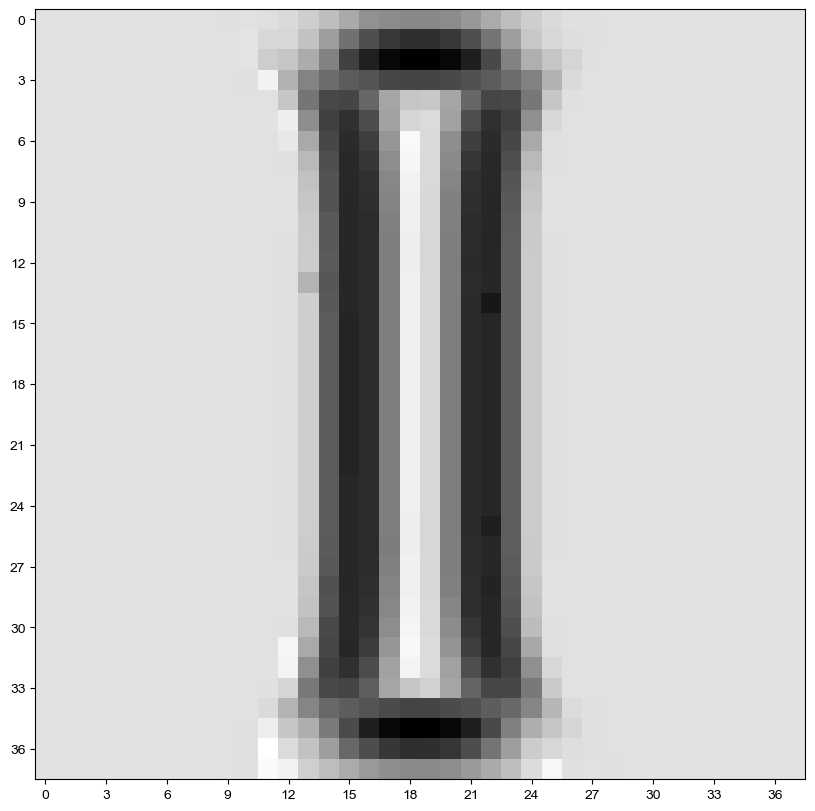

C:\Users\haloe\Documents\CodeWriting\4Denoise\helpers\fourdenoise.py:2802: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(np.mean(self.array, axis=(0,1))*detector_mask), cmap='turbo',)


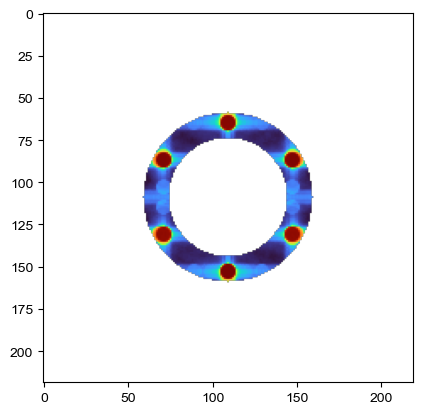

In [298]:
plt.figure(figsize=(10,10))
ripple_dataset.get_virtualImage(r_minor=35, r_major=50, plotMask=True, grid=False)
plt.show()

Generate 5D dataset using the infinite-dose *abTEM*-generated 4D dataset, with the first dimension varying the dose level.

In [299]:
# Parameters
area = np.pi * 14.054717063903809**2 / 4 # FWHM area in angstroms, calculated from `dp_flat` diffraction pattern
doses = np.array([1e7, 1e6, 1e5, 1e4, 1e3, 1e2]) * area 
num_doses = len(doses)

In [280]:
ry, rx = ripple_dataset.shape[:2]
ky, kx = ripple_dataset.shape[2:]

# Initialize simulated 5D dataset
noisy_datasets_high_to_low = np.zeros((num_doses, ry, rx, ky, kx), dtype=np.float32)

for i in tqdm(range(ry)):
    for j in range(rx):

        # Simulate infinite dose diffraction pattern
        dp = ripple_dataset.get_dp(i, j).array # if `ripple_dataset` is a HyperData object
        # dp = ripple_dataset[i, j]              # if `ripple_dataset` is a numpy array
        dp /= dp.sum()

        # Apply multiple dose levels
        for idx, dose in enumerate(doses):

            # Apply Poisson noise for the given dose
            dp_noisy = np.random.poisson(dp*dose)
        
            # Store the obtained diffraction pattern
            noisy_datasets_high_to_low[idx, i, j] = dp_noisy

100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [01:10<00:00,  1.84s/it]


In [514]:
np.save('noisy_datasets_high_to_low_highRes.npy', noisy_datasets_high_to_low)

### Data processing step: Bragg peak center-of-mass finding

We need reference coordinates to enable **center-of-mass** finding, to do this, we can find the peaks using one of two options (other methods are available but not implemented in this Jupyter notebook):
1. `select_peaks`(manual option, simple in this case, for we seek 6 second-order Bragg peaks only)
2. **abTEM** method `.index_diffraction_spots` (longer process, but more automatic)

#### Finding peaks via `select_peaks`

The option below opens a window where peaks are directly clicked, as shown below (the button "**ENTER**" must be clicked or the kernel will keep running regardless of whether the window is closed. This will be fixed in a latter release of 4Denoise)

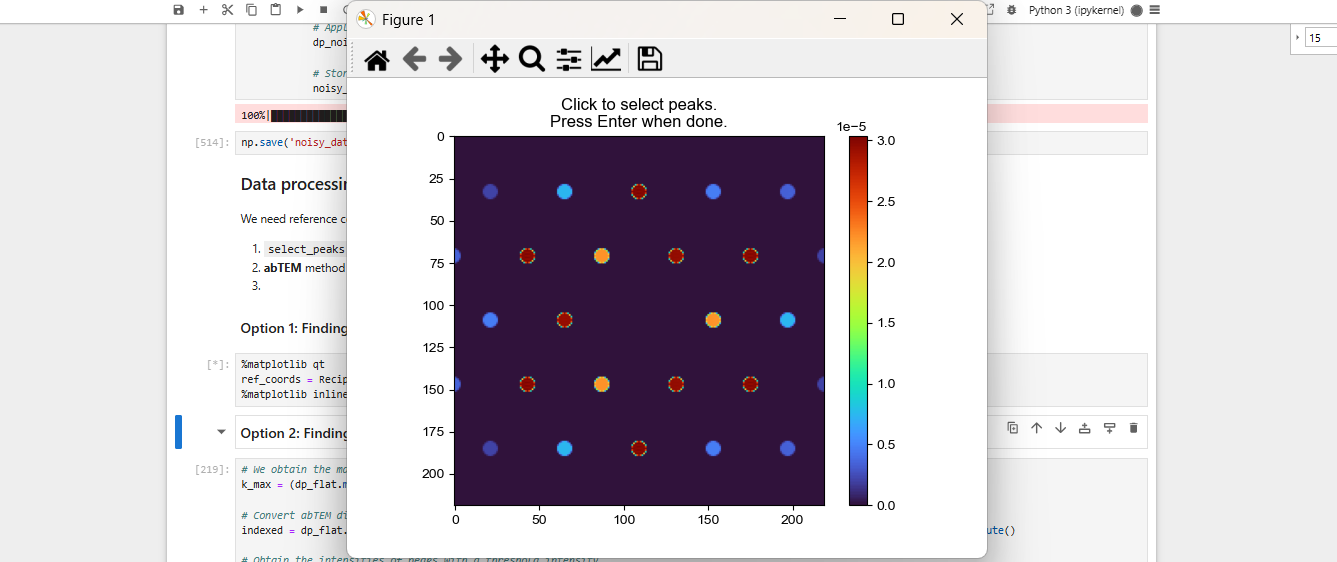

In [288]:
ripple_dataset.shape

(38, 38, 219, 219)

In [305]:
# Obtain a representative "flat" diffraction pattern from the data
ripple_flat_region = ripple_dataset.get_dp(y=(0,38), x=(0,5))

In [307]:
%matplotlib qt
ref_coords = ripple_flat_region.select_peaks(cmap='turbo',)
%matplotlib inline

In [308]:
ref_coords

array([[ 43.58441558, 147.51461039],
       [109.94805195, 184.84415584],
       [173.94155844, 146.92207792],
       [174.53409091,  70.48538961],
       [109.35551948,  32.56331169],
       [ 41.80681818,  70.48538961]])

**Note:** Below, we add a small number (e.g., 1e-10) to all pixels of the dataset to allow for center-of-mass calculations (this will be fixed in a latter release of 4Denoise package)

In [309]:
# Compute centers of mass for 4D dataset
all_centers = np.zeros((6, ry,  rx, 6, 2))

for i in range(num_doses):
    centers = HyperData(noisy_datasets_high_to_low[i]+1e-10).get_centers(r=6, ref_coords=ref_coords, method='CoM')
    all_centers[i] = centers

Computing centers (4D): 100%|██████████████████████████████████████████████████████████| 38/38 [00:08<00:00,  4.54it/s]


### Data processing step: Bragg peak intensity integration

Compute intensities for each dose map

In [310]:
# Compute intensities for all diffraciton patterns in 4D dataset
all_intensities = np.zeros((6, ny,  nx, 6))

for i in range(num_doses):
    
    # Instantiate 4D data as a HyperData object
    dataset = HyperData(noisy_datasets_high_to_low[i])

    # Compute intensities
    intensities = dataset.get_intensities(r=5.5, centers=all_centers[i], method='CoM')

    # For normalization
    flat_intensities = dataset.get_dp((0,38), (0,7)).get_intensities(r=5.5, centers=ref_coords, method='CoM')

    # Store
    all_intensities[i] = intensities/flat_intensities

Calculating intensities: 100%|█████████████████████████████████████████████████████████| 38/38 [00:09<00:00,  3.90it/s]


Visualize the same diffraction pattern (randomly picked) at different dose levels

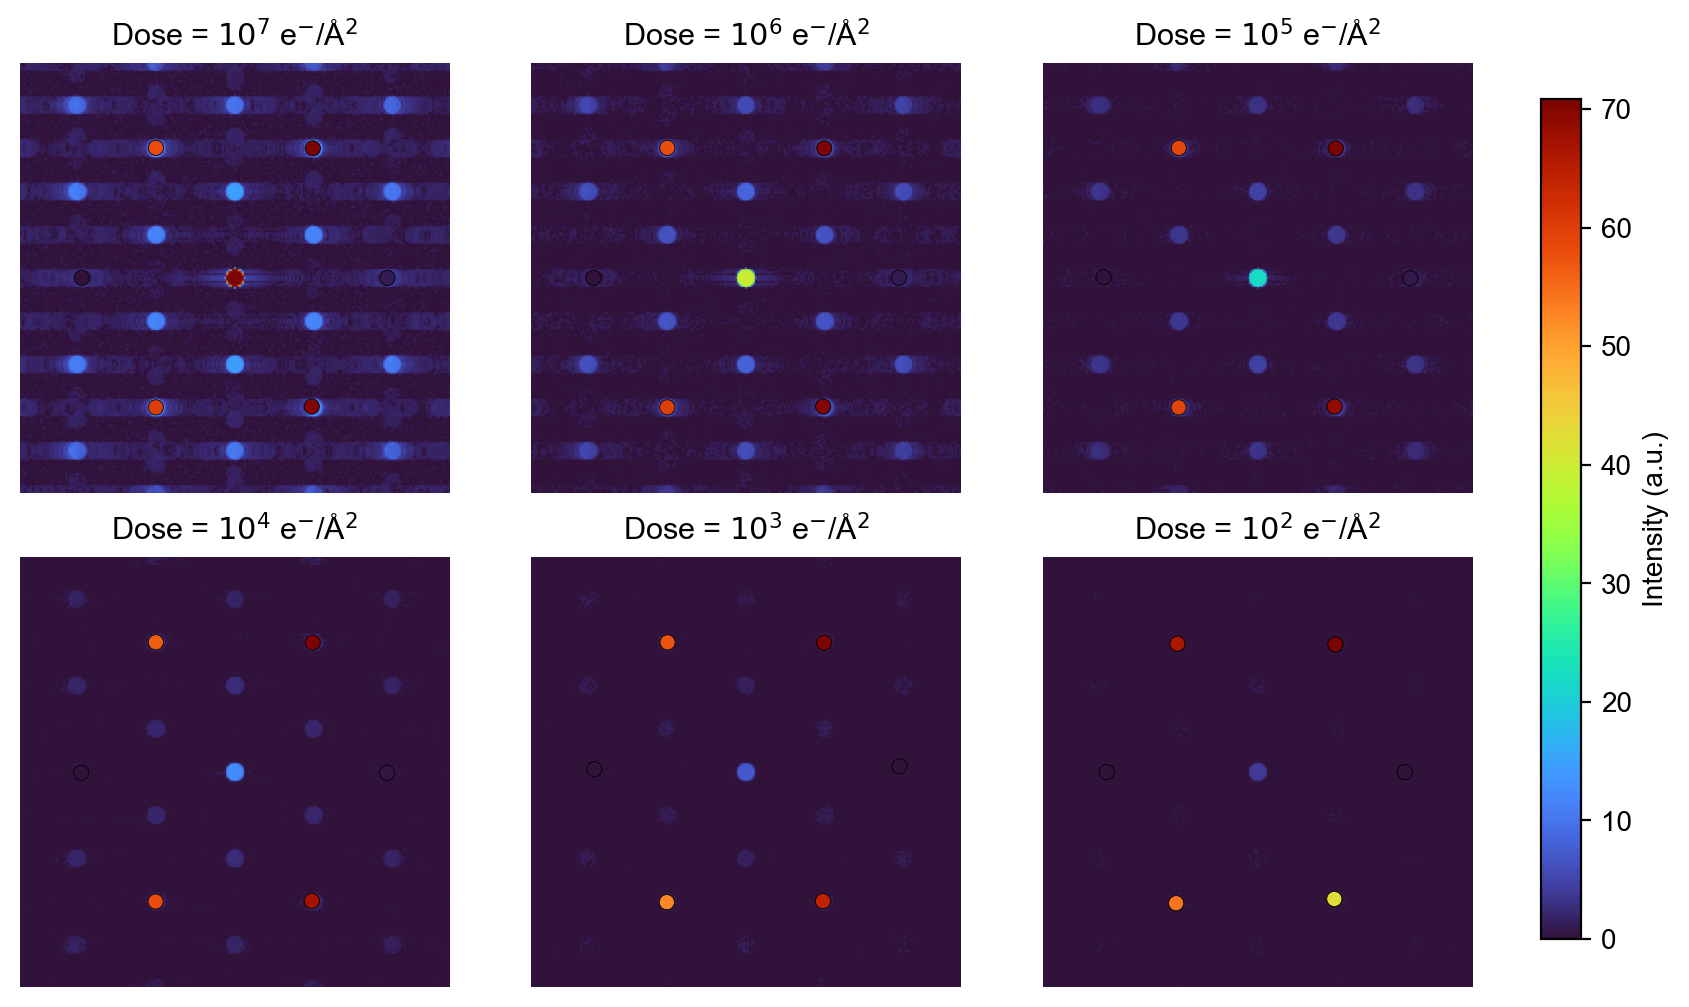

In [319]:
a, b = np.random.randint(0, 38), np.random.randint(0, 38)
dose_labels = [r"$10^7$", r"$10^6$", r"$10^5$", r"$10^4$", r"$10^3$", r"$10^2$"]
gamma = 0.25  # power for visibility
cmap_name = "turbo"
dot_size = 30

fig, axs = plt.subplots(2, 3, figsize=(10, 6), dpi=200)
axs = axs.ravel()

# Normalize across all plots
vmin = min(np.min(noisy_datasets_high_to_low[i, a, b]) for i in range(6))
vmax = max(np.max(noisy_datasets_high_to_low[i, a, b]) for i in range(6))

for i, ax in enumerate(axs):
    dp = noisy_datasets_high_to_low[i, a, b]

    im = ax.imshow(dp**gamma, cmap=cmap_name, vmin=vmin**gamma, vmax=vmax**gamma)
    ax.scatter(
        all_centers[i, a, b, :, 1],
        all_centers[i, a, b, :, 0],
        c=all_intensities[i, a, b, :],
        cmap=cmap_name,
        s=dot_size,
        edgecolors="k",
        linewidths=0.3
    )
    ax.set_title(f"Dose = {dose_labels[i]} e$^{{-}}$/Å$^2$", fontsize=11)
    ax.axis("off")

# Shared colorbar
fig.subplots_adjust(right=0.88, wspace=0.05, hspace=0.15)
cbar_ax = fig.add_axes([0.90, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax, label="Intensity (a.u.)")

plt.show()


### Compute tilt map for each dose level map

In [3]:
model_ints_array = np.load('./sim_ints_MoSe2_many.npy')

In [566]:
all_tilts = np.zeros((6, ry, rx, 2))

for i in range(num_doses):
    
    all_tilts[i] = get_tilts(intensity_array=all_intensities[i],
                             show_result=False,
                             method='grid_search', 
                             loss='euclidean_distance', 
                             simDataArray=model_ints_array,)

Finding optimal (phi, theta): 100%|████████████████████████████████████████████████████| 38/38 [05:19<00:00,  8.42s/it]


In [567]:
np.save('all_tilts.npy', all_tilts)

In [320]:
all_tilts = np.load('all_tilts.npy')

In [10]:
all_grads = np.zeros((6, ry, rx, 2))

for i in range(num_doses):
    
    all_grads[i] = get_gradients(all_tilts[i], 
                                  rot_angle=-100,    # 'rot_angle' is for use to specify the positive/negative X and Y directions 
                                  show_result=False, 
                                  invertY=True,      # Make sure that positive direction of y-gradient is out-of-screen downward
                                  invertX=True,      # Make sure that positive direction of x-gradient is out-of-screen going to the right
                                  cbar_fraction=0.031) 

**Note:** The code below redundantly reconstructs using a certain number of iterations to compute the error, then restarts. This will be updated in a latter release.

In [12]:
# Define the range for iterations and select 10 evenly spaced values
iterations_range = np.linspace(3,150,15,).astype(int)
all_errors = np.zeros((6,15))

for i in range(6):
   
    # Placeholder for errors
    errors = []
    
    # Loop over the selected iteration values
    for it in iterations_range:
        # Compute hmap using the current iteration value
        hmap = reconstruct_height(xGrad=all_grads[i,:,:,0], yGrad=all_grads[i,:,:,1], 
                                  y_bds_flat=(10,28), 
                                  x_bds_flat=(0,13), 
                                  iterations=it, 
                                  threshold_percent=0.3, 
                                  max_window_size=5, 
                                  plot=False)[0]
        hmap -= np.mean(hmap[:37,:13])
        
        # Compute the error as the norm difference
        error = np.linalg.norm(hmap - ripple_map)
        errors.append(error)
    
    all_errors[i] = np.array(errors)

C:\Users\haloe\Documents\CodeWriting\4Denoise\helpers\fourdenoise.py:1153: RuntimeWarning: divide by zero encountered in reciprocal
  q2inv = np.reciprocal(q2a)
Reconstructing height: 100%|█████████████████████████████████████████████████████████| 150/150 [02:34<00:00,  1.03s/it]


In [13]:
np.save('all_errors.npy', all_errors)

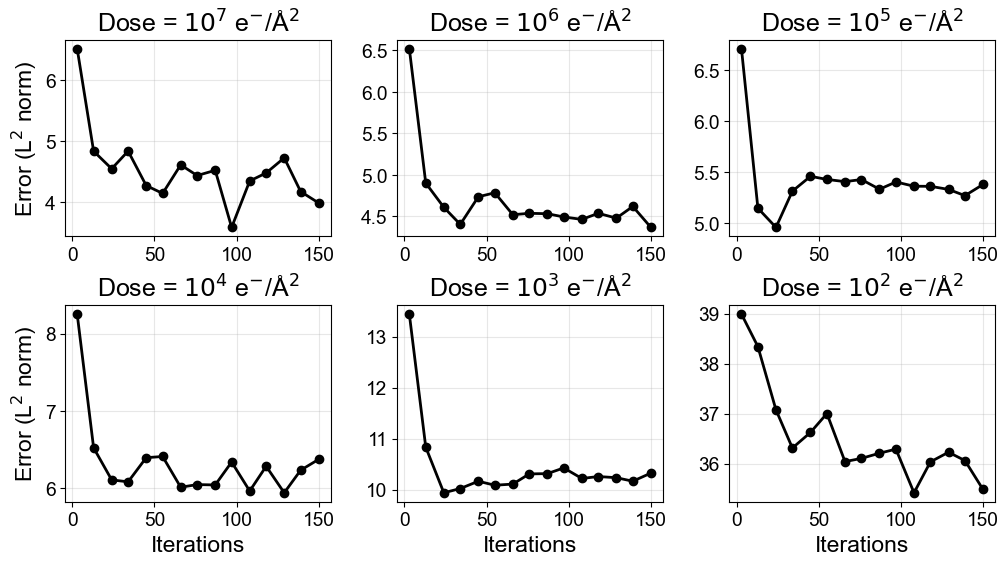

Final-iteration L2 error (nm·sqrt(px)) by dose:
$10^7$: 3.98831
$10^6$: 4.36628
$10^5$: 5.38162
$10^4$: 6.37557
$10^3$: 10.3232
$10^2$: 35.4836


In [76]:
scale_nm_per_px = 2.5
title_size      = 18
axis_label_size = 16.5
tick_label_size = 13.8
line_width      = 2.0
marker_size     = 6
grid_alpha      = 0.3
wspace, hspace  = 0.25, 0.35   # subplot spacing

# Inputs expected:
dose_labels_math = [r"$10^7$", r"$10^6$", r"$10^5$", r"$10^4$", r"$10^3$", r"$10^2$"]

# Unit conversion
all_errors_nm = [scale_nm_per_px * np.asarray(err, dtype=float) for err in all_errors]

fig, axs = plt.subplots(2, 3, figsize=(12, 6))
fig.subplots_adjust(wspace=wspace, hspace=hspace)

for i in range(6):
    r, c = divmod(i, 3)
    ax = axs[r, c]
    errs_nm = all_errors_nm[i]

    ax.plot(
        iterations_range,
        errs_nm,
        marker='o',
        linewidth=line_width,
        markersize=marker_size,
        color='black',
        label='L2 error'
    )

    # Per-panel y-limits with small padding; clamp low end at 0 
    finite_vals = errs_nm[np.isfinite(errs_nm)]
    if finite_vals.size:
        y_max = np.max(finite_vals)
        y_min = np.min(finite_vals)
        span  = y_max - y_min
        pad   = 0.05 * (span if span > 0 else (y_max if np.isfinite(y_max) else 1.0))
        y_lo, y_hi = max(0.0, y_min - pad), y_max + pad
        if not np.isfinite(y_lo) or not np.isfinite(y_hi) or y_lo == y_hi:
            y_lo, y_hi = 0.0, (y_max if np.isfinite(y_max) else 1.0) * 1.05 + 1e-9
        ax.set_ylim(y_lo, y_hi)

    # Title and tick sizes
    ax.set_title(fr'Dose = {dose_labels_math[i]} e$^{{-}}$/Å$^2$', fontsize=title_size)
    ax.grid(True, alpha=grid_alpha)
    ax.tick_params(axis='both', labelsize=tick_label_size)

    # Axis labels only where requested
    if c == 0:  # left-most column
        ax.set_ylabel(r'Error (L$^2$ norm)', fontsize=axis_label_size)
    else:
        ax.set_ylabel("")
    if r == 1:  # bottom row
        ax.set_xlabel('Iterations', fontsize=axis_label_size)
    else:
        ax.set_xlabel("")

plt.show()

In [33]:
all_hmaps = np.zeros((6, ry, rx))

for i in range(num_doses):
    
    hmap = reconstruct_height(xGrad=all_grads[i,:,:,0], yGrad=all_grads[i,:,:,1], 
                          y_bds_flat=(0,30), 
                          x_bds_flat=(0,190), 
                          iterations=80, 
                          threshold_percent=0.3, 
                          max_window_size=5, 
                          plot=False)[0]
    
    all_hmaps[i] = hmap - np.mean(hmap[:37,:13])

Reconstructing height: 100%|███████████████████████████████████████████████████████████| 80/80 [01:25<00:00,  1.07s/it]


In [34]:
np.save('all_hmaps.npy', all_hmaps)

In [35]:
ripple_map = np.load('geometric_ripple.npy')

### We also obtain the height map for the infinite-dose version of the ripple data

In [334]:
ripple_data = np.load('simulated_4d_dataset_highRes.npy')

In [339]:
flat_intensities = ripple_flat_region.get_intensities(r=6.5, method='CoM', ref_coords=ref_coords,)

In [340]:
ripple_data = HyperData(ripple_data)

# Compute centers of mass for 4D dataset
centers_inf = ripple_data.get_centers(r=6.5, ref_coords=ref_coords, method='CoM')

# Compute intensities for all diffraciton patterns in 4D dataset
intensities_inf = ripple_data.get_intensities(r=6.5, centers=centers_inf,)

Calculating intensities: 100%|█████████████████████████████████████████████████████████| 38/38 [00:12<00:00,  3.10it/s]


In [341]:
# Normalize as required for the height-mapping algorithm
intensities_inf /= flat_intensities

In [343]:
options= ['load', 'generate']
option = options[0] # [0] to load or [1] to generate data

if option in options:
    if option == 'load':
        model_ints_array = np.load('./sim_ints_MoSe2_many.npy')
    else:
        model_ints_array = generate_library(phi_range=(0,360), num_phis=721,       # Specify range and number of values simulated    
                                      theta_range=(0,25), num_thetas=1251,     # Specify range and number of values simulated        
                                      save=True, fname='sim_ints_MoSe2_many.npy', # Optionaly, save the generated library
                                      material='MoSe2', a=3.32, order=2,     # Kinematic diffraction simulation arguments
                                      normalization='flat_max', keV=80,      # Kinematic diffraction simulation arguments
                                     )
        
else:
    print("To either load or generate simulation data, you must assign the right option.")

Finding optimal (phi, theta): 100%|████████████████████████████████████████████████████| 38/38 [02:46<00:00,  4.39s/it]


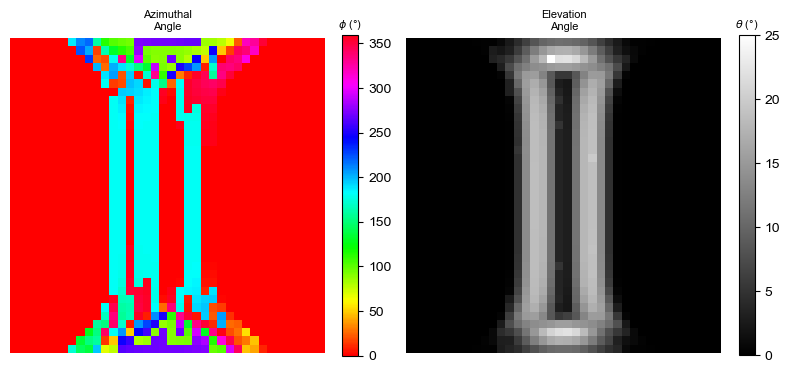

In [344]:
tilts = get_tilts(intensity_array=intensities_inf,
                  show_result=True, figsize=(8, 8),
                  method='grid_search', 
                  loss='euclidean_distance', 
                  simDataArray=model_ints_array,)

We show the gradient maps according to the solution found by `get_tilts`. Note that the sign of the gradient is fixed during the reconstruction.

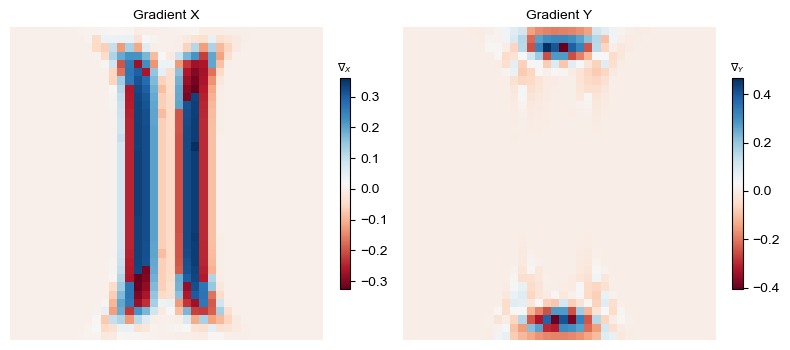

In [345]:
grads = get_gradients(tilts, 
                      rot_angle=-90, # 'rot_angle' is for use to specify the positive/negative X and Y directions 
                      show_result=True, invertY=True, invertX=True,
                      cbar_fraction=0.031) 

In [346]:
inf_dose = reconstruct_height(xGrad=grads[:,:,0], yGrad=grads[:,:,1], 
                          y_bds_flat=(10,28), 
                          x_bds_flat=(0,13), 
                          iterations=80, 
                          threshold_percent=0.6, 
                          max_window_size=5, 
                          plot=False)[0]

C:\Users\haloe\Documents\CodeWriting\4Denoise\helpers\fourdenoise.py:1153: RuntimeWarning: divide by zero encountered in reciprocal
  q2inv = np.reciprocal(q2a)
Reconstructing height: 100%|███████████████████████████████████████████████████████████| 80/80 [01:47<00:00,  1.35s/it]


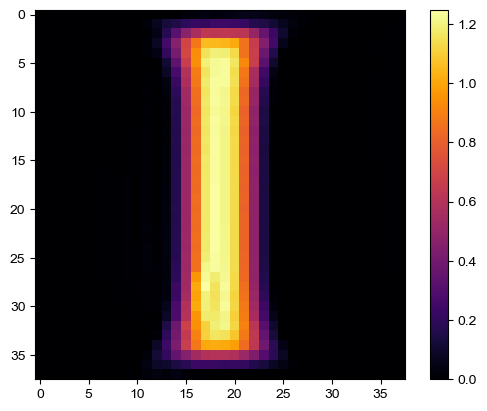

In [347]:
plt.imshow(inf_dose, cmap='inferno', vmin=0)
plt.colorbar()
plt.show()

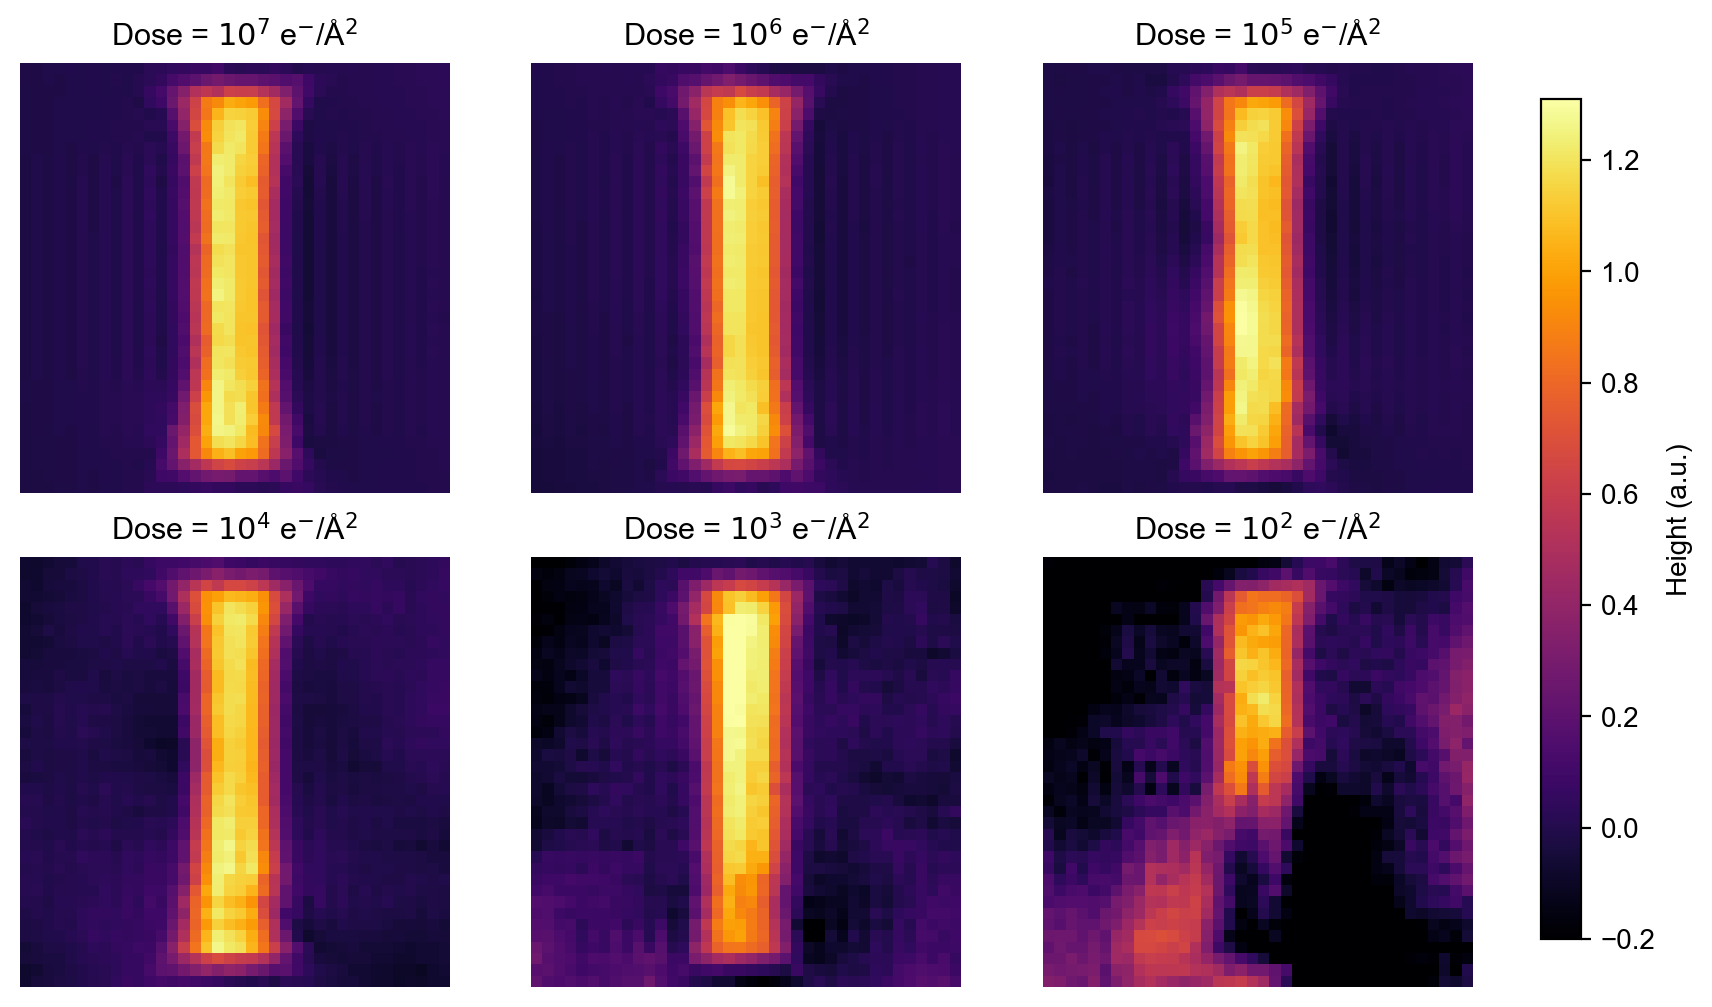

In [330]:
dose_labels = [r"$10^7$", r"$10^6$", r"$10^5$", r"$10^4$", r"$10^3$", r"$10^2$"]
cmap_name = "inferno"

fig, axs = plt.subplots(2, 3, figsize=(10, 6), dpi=200)
axs = axs.ravel()

# Compute global color range across all height maps for consistent contrast
vmin = min(np.nanmin(all_hmaps[i]) for i in range(6))*0.95
vmax = max(np.nanmax(all_hmaps[i]) for i in range(6))*0.95

for i, ax in enumerate(axs):
    im = ax.imshow(all_hmaps[i], cmap=cmap_name, vmin=-0.2, vmax=vmax)
    ax.set_title(f"Dose = {dose_labels[i]} e$^{{-}}$/Å$^2$", fontsize=11)
    ax.axis("off")

# Shared colorbar
fig.subplots_adjust(right=0.88, wspace=0.05, hspace=0.15)
cbar_ax = fig.add_axes([0.90, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax, label="Height (a.u.)")

plt.show()


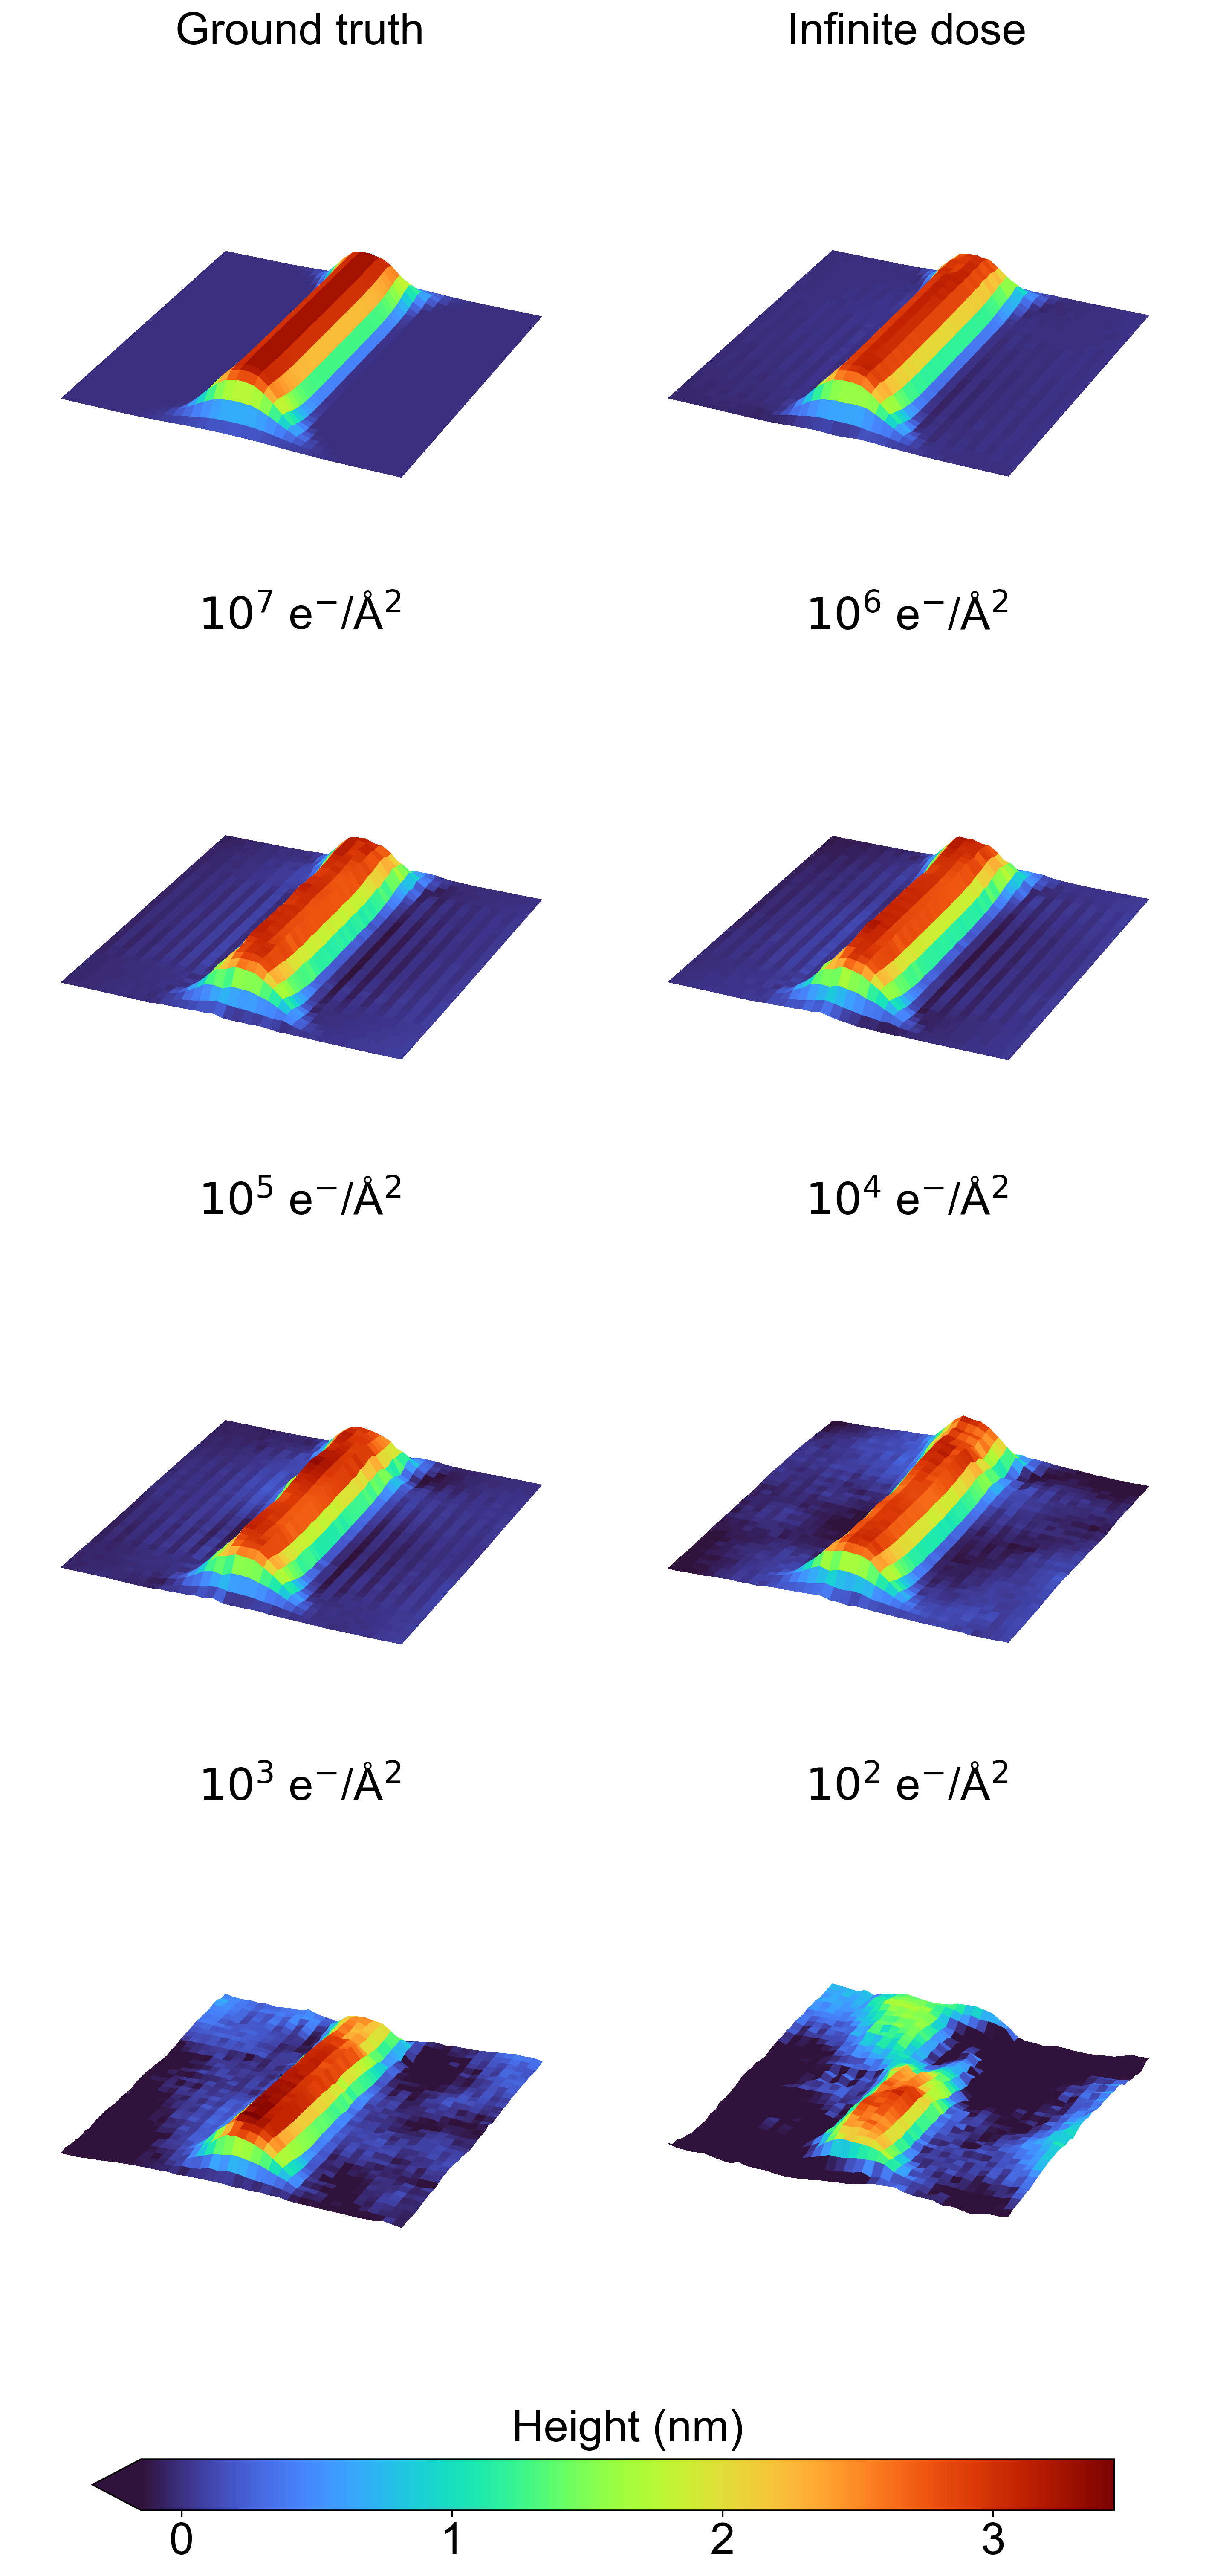

In [59]:
import matplotlib as mpl

height_scale_nm_per_px = 2.5    # convert heights: nm per pixel
z_exag      = 15.0              # vertical exaggeration (visualization only)
elev, azim  = 27.5, -65         # 3D camera view
cmap_name   = "turbo"           # colormap for heights

title_size  = 25                # subplot title fontsize
title_pad   = 2                 # distance from subplot (points)
axes_off    = True              # hide axes/frames/ticks on each 3D panel

# spacing/margins
wspace, hspace = 0.02, 0.02
margins = dict(left=0.03, right=0.97, bottom=0.08, top=0.98)

# colorbar stuff
cbar_title        = "Height (nm)"
cbar_title_size   = 25
cbar_title_pad    = 10          # gap bet. bar and its title
cbar_tick_size    = 25
cbar_fraction     = 0.05        # colorbar thickness (frac)
cbar_pad          = 0.03        # gap bet.  panels/colorbar
cbar_shrink       = 0.85        # length of colorbar (frac of fig)

maps = [
    ripple_map,                 
    inf_dose,                   
    all_hmaps[0],               
    all_hmaps[1],               
    all_hmaps[2],               
    all_hmaps[3],               
    all_hmaps[4],               
    all_hmaps[5],               
]

titles = [
    "Ground truth",
    "Infinite dose",
    r"$10^7$ e$^{-}$/Å$^2$",
    r"$10^6$ e$^{-}$/Å$^2$",
    r"$10^5$ e$^{-}$/Å$^2$",
    r"$10^4$ e$^{-}$/Å$^2$",
    r"$10^3$ e$^{-}$/Å$^2$",
    r"$10^2$ e$^{-}$/Å$^2$",
]

# Coordinates
A, B = ripple_map.shape
y = np.arange(A)
x = np.arange(B)
X, Y = np.meshgrid(x, y, indexing="xy")

try:
    cmap = mpl.colormaps.get_cmap(cmap_name)
except Exception:
    cmap = mpl.colormaps.get_cmap("turbo")

# global color scale 
stack = np.stack(maps, axis=0)                       # (8, A, B)
stack_nm = stack*height_scale_nm_per_px              # convert to nm
data_max = float(np.nanmax(stack_nm))
norm = mpl.colors.Normalize(vmin=-0.15, vmax=data_max)

# Figure and 3D axes
fig = plt.figure(figsize=(10, 22), dpi=300)
axs = [fig.add_subplot(4, 2, i + 1, projection="3d") for i in range(8)]

def hide_3d_axes(ax):
    ax.set_xticks([]); ax.set_yticks([]); ax.set_zticks([])
    ax.set_xlabel(""); ax.set_ylabel(""); ax.set_zlabel("")
    ax.grid(False)
    # Make panes/inset lines fully transparent
    for axis in (ax.xaxis, ax.yaxis, ax.zaxis):
        axis.pane.set_edgecolor((1, 1, 1, 0))
        axis.pane.set_facecolor((1, 1, 1, 0))
        axis.line.set_color((1, 1, 1, 0))
    if axes_off:
        ax.set_axis_off()

# Plot panels
for ax, Z_px, title in zip(axs, maps, titles):
    Z_nm = Z_px * height_scale_nm_per_px       # <-- conversion here (nm)
    facecolors = cmap(norm(Z_nm))              # color by *true* (unexaggerated) nm
    Zplot = Z_nm * z_exag                      # exaggerate Z only for display

    ax.plot_surface(
        X, Y, Zplot,
        facecolors=facecolors,
        rstride=1, cstride=1,
        linewidth=0, antialiased=False, shade=False
    )
    ax.view_init(elev=elev, azim=azim)
    ax.set_title(title, fontsize=title_size, pad=title_pad)
    ax.set_box_aspect((B, A, 0.1 * max(data_max, 1e-12) * z_exag))
    hide_3d_axes(ax)

# Tighten spacing between subplots
fig.subplots_adjust(wspace=wspace, hspace=hspace, **margins)

# Shared colorbar at the bottom (horizontal), label *above*, ticks *below*
mappable = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
mappable.set_array([])
cbar = fig.colorbar(
    mappable, ax=axs, orientation="horizontal", location="bottom",
    fraction=cbar_fraction, pad=cbar_pad, shrink=cbar_shrink, extend="min"
)

# Put the title above the bar; keep ticks below
cbar.ax.xaxis.set_label_position('top')
cbar.ax.xaxis.set_ticks_position('bottom')
cbar.ax.set_xlabel(cbar_title, fontsize=cbar_title_size, labelpad=cbar_title_pad)
cbar.ax.tick_params(axis='x', labelsize=cbar_tick_size)

plt.show()

We plot the error on the ripple region of the dataset (exclude flat region as much as possible)

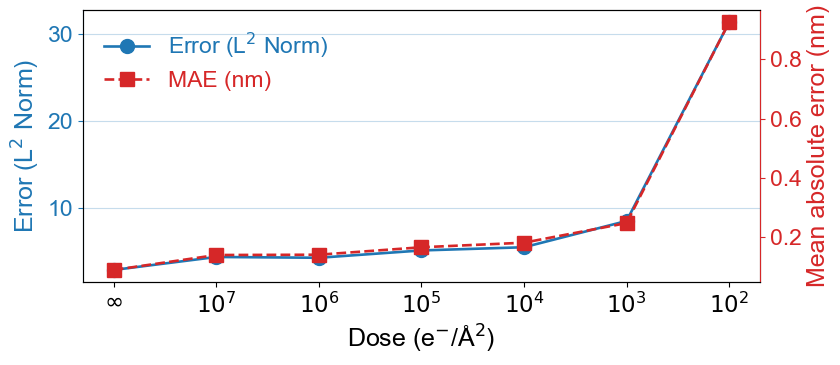

Dose, L2 Norm(Error) [nm·sqrt(px in ROI [:,13:28])], MAE(nm)
$\infty$: 2.8522, 0.089688
$10^7$: 4.34504, 0.140008
$10^6$: 4.25257, 0.141047
$10^5$: 5.09561, 0.166146
$10^4$: 5.46156, 0.181564
$10^3$: 8.48069, 0.247698
$10^2$: 31.3217, 0.924343


In [163]:
def masked_diff_roi(a, b, roi):
    """Flattened (a - b) on ROI with shared finite mask."""
    a_roi = a[roi]; b_roi = b[roi]
    mask = np.isfinite(a_roi) & np.isfinite(b_roi)
    return (a_roi[mask] - b_roi[mask]).ravel()

def l2_error_nm(a_nm, b_nm, roi):
    d = masked_diff_roi(a_nm, b_nm, roi)
    return np.linalg.norm(d) if d.size else np.nan   # nm·sqrt(px_in_ROI)

def mae_nm(a_nm, b_nm, roi):
    d = masked_diff_roi(a_nm, b_nm, roi)
    return np.mean(np.abs(d)) if d.size else np.nan  # nm
    
height_scale_nm_per_px = 2.5   # convert height px to nm
tick_label_size  = 11*1.5
axis_label_size  = 12*1.5
legend_size      = 11*1.5
marker_size      = 10
line_width       = 1.9
x_label = r"Dose (e$^{-}$/Å$^2$)"
grid_y = True

# ROI
roi_col_start, roi_col_stop = 13, 28 

dose_labels_math = [r"$\infty$", r"$10^7$", r"$10^6$", r"$10^5$", r"$10^4$", r"$10^3$", r"$10^2$"]
dose_maps_px = [inf_dose] + [all_hmaps[i] for i in range(6)]

# Convert to nm
GT_nm = ripple_map * height_scale_nm_per_px
dose_maps_nm = [m * height_scale_nm_per_px for m in dose_maps_px]

# define ROI based on input width
A, B = GT_nm.shape
start = max(0, min(B, roi_col_start))
stop  = max(start + 1, min(B, roi_col_stop))  # ensure at least 1 column
roi = (slice(None), slice(start, stop))       # [:, start:stop)

# compute metrics on ROI
norm_vals = [l2_error_nm(m, GT_nm, roi) for m in dose_maps_nm]  # nm·sqrt(px in ROI)
mae_vals  = [mae_nm(m, GT_nm, roi)       for m in dose_maps_nm] # nm

fig, ax_left = plt.subplots(figsize=(8.5, 3.75))
x = np.arange(len(dose_labels_math))
roi_text = f"ROI [:,{start}:{stop}]"

# Left axis: L2 Norm(Error) — BLUE
left_color  = "tab:blue"
right_color = "tab:red"

ln1 = ax_left.plot(
    x, norm_vals, marker="o", linewidth=line_width, markersize=marker_size,
    color=left_color, label=r"Error (L$^2$ Norm)"
)[0]
ax_left.set_xlabel(x_label, fontsize=axis_label_size)
ax_left.set_xticks(x, dose_labels_math, fontsize=tick_label_size)
ax_left.set_ylabel(r"Error (L$^2$ Norm)",
                   fontsize=axis_label_size, color=left_color)
ax_left.tick_params(axis='y', labelsize=tick_label_size, colors=left_color)
ax_left.spines['left'].set_color(left_color)
if grid_y:
    ax_left.grid(True, which="major", axis="y", alpha=0.25, color=left_color)

# Right axis: MAE — RED
ax_right = ax_left.twinx()
ln2 = ax_right.plot(
    x, mae_vals, marker="s", linestyle="--", linewidth=line_width, markersize=marker_size,
    color=right_color, label="MAE (nm)"
)[0]
ax_right.set_ylabel("Mean absolute error (nm)",
                    fontsize=axis_label_size, color=right_color)
ax_right.tick_params(axis='y', labelsize=tick_label_size, colors=right_color)
ax_right.spines['right'].set_color(right_color)

# Shared legend with colored entries
lines = [ln1, ln2]
labels = [l.get_label() for l in lines]
leg = ax_left.legend(lines, labels, loc="best", fontsize=legend_size, frameon=False)
for txt, col in zip(leg.get_texts(), [left_color, right_color]):
    txt.set_color(col)

fig.tight_layout()
plt.show()

# Numeric log
print(f"Dose, L2 Norm(Error) [nm·sqrt(px in {roi_text})], MAE(nm)")
for lbl, nval, mval in zip(dose_labels_math, norm_vals, mae_vals):
    print(f"{lbl:>6s}: {nval:.6g}, {mval:.6g}")
